# Imports and Dataset Loading

In [1]:
# Import all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import check_array
from scikeras.wrappers import KerasRegressor 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error,roc_auc_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow import keras
from keras import layers, models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# load the dataset
insurance_data = pd.read_csv('insurance_claim_data.csv')

In [3]:
# Change the following columns to datetime objects
insurance_data['Accident Date'] = pd.to_datetime(insurance_data['Accident Date'])
insurance_data['Claim Date'] = pd.to_datetime(insurance_data['Claim Date'])

# Exploratory Data Analysis (EDA)

### Overall Dataset Understanding

In [4]:
# display the first 5 rows of the dataset
insurance_data.head()

,SettlementValue,AccidentType,Injury_Prognosis,SpecialHealthExpenses,SpecialReduction,SpecialOverage,GeneralRest,SpecialAdditionalInjury,SpecialEarningsLoss,SpecialUsageLoss,...,Accident Date,Claim Date,Vehicle Age,Driver Age,Number of Passengers,Accident Description,Injury Description,Police Report Filed,Witness Present,Gender
0,520.0,Rear end,E. 5 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2023-11-10 11:22:24.508901,2024-06-11 11:22:24.508901,13.0,33.0,4.0,Side collision at an intersection.,Whiplash and minor bruises.,Yes,Yes,Male
1,870.0,Rear end,B. 2 months,0.0,0.0,0.0,520.0,0.0,0.0,90.0,...,2023-06-25 00:55:01.140228,2024-01-09 00:55:01.140228,4.0,45.0,2.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female
2,2140.0,Other side pulled out of side road,G. 7 months,0.0,0.0,0.0,1400.0,0.0,0.0,0.0,...,2020-02-23 17:43:47.805561,2020-03-01 17:43:47.805561,9.0,45.0,4.0,Lost control on a snowy road.,Whiplash and minor bruises.,Yes,No,Female
3,520.0,Rear end - Clt pushed into next vehicle,D. 4 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2021-10-02 04:36:32.118423,2021-10-13 04:36:32.118423,5.0,62.0,1.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female
4,260.0,Rear end,C. 3 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2023-04-02 05:13:07.117423,2023-04-14 05:13:07.117423,9.0,78.0,1.0,Lost control on a snowy road.,Concussion and bruised ribs.,Yes,Yes,Other


In [5]:
# check the dimension of the data
insurance_data.shape

(5000, 36)

In [6]:
missing_counts = insurance_data.isnull().sum(axis=1)

# Count rows with at least 1, 2, and 3 missing values
at_least_1_missing = (missing_counts >= 1).sum()
at_least_2_missing = (missing_counts >= 2).sum()
at_least_3_missing = (missing_counts >= 3).sum()

print(f"Number of rows with at least 1 missing feature: {at_least_1_missing}")
print(f"Number of rows with at least 2 missing features: {at_least_2_missing}")
print(f"Number of rows with at least 3 missing features: {at_least_3_missing}")

Number of rows with at least 1 missing feature: 1455
Number of rows with at least 2 missing features: 1150
Number of rows with at least 3 missing features: 822


In [7]:
# check all the data columns
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   SettlementValue             4894 non-null   float64       
 1   AccidentType                4878 non-null   object        
 2   Injury_Prognosis            4844 non-null   object        
 3   SpecialHealthExpenses       4870 non-null   float64       
 4   SpecialReduction            4879 non-null   float64       
 5   SpecialOverage              4883 non-null   float64       
 6   GeneralRest                 4872 non-null   float64       
 7   SpecialAdditionalInjury     4866 non-null   float64       
 8   SpecialEarningsLoss         4872 non-null   float64       
 9   SpecialUsageLoss            4870 non-null   float64       
 10  SpecialMedications          4870 non-null   float64       
 11  SpecialAssetDamage          4889 non-null   float64     

In [8]:
# compute the statistical summary of the insurance data
insurance_data.describe()

,SettlementValue,SpecialHealthExpenses,SpecialReduction,SpecialOverage,GeneralRest,SpecialAdditionalInjury,SpecialEarningsLoss,SpecialUsageLoss,SpecialMedications,SpecialAssetDamage,...,GeneralUplift,SpecialLoanerVehicle,SpecialTripCosts,SpecialJourneyExpenses,SpecialTherapy,Accident Date,Claim Date,Vehicle Age,Driver Age,Number of Passengers
count,4894.000000,4870.000000,4879.0,4883.000000,4872.000000,4866.000000,4872.000000,4870.000000,4870.000000,4889.000000,...,4863.000000,4861.000000,4885.000000,4853.000000,4868.000000,4862,4891,4874.000000,4871.000000,4878.000000
mean,1218.010685,3.611704,0.0,13.363580,463.305386,0.283580,52.191115,9.108830,0.109698,33.460761,...,10.407465,7.719720,1.959881,11.639120,183.600286,2021-12-24 21:20:25.092965376,2022-06-23 02:32:25.291450112,9.508617,48.789160,2.482370
min,240.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01-01 00:00:00,2020-01-05 15:05:04.620924,0.000000,18.000000,1.000000
25%,669.140000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2020-12-27 06:37:48.453690112,2021-06-23 04:34:05.209040896,4.000000,33.000000,1.000000
50%,988.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,50.000000,2021-12-15 08:59:49.197839104,2022-06-15 23:32:38.071613952,10.000000,49.000000,2.000000
75%,1510.000000,0.000000,0.0,0.000000,906.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,350.000000,2022-12-18 22:51:43.820763904,2023-06-22 03:51:09.973994496,14.000000,64.000000,3.000000
max,7862.900000,3024.000000,0.0,1250.000000,3912.640000,889.000000,7735.580000,1050.000000,30.250000,6070.000000,...,1430.000000,4408.160000,254.200000,880.000000,1225.000000,2023-12-31 00:00:00,2024-12-08 06:47:01.524304,19.000000,79.000000,4.000000
std,858.866309,85.047845,0.0,84.223612,766.187669,12.988075,392.909130,65.505181,1.389916,282.692529,...,50.165743,141.155658,13.117419,49.086924,223.885780,NaN,NaN,5.727625,17.819725,1.109911


In [9]:
# check the unique values in the data
insurance_data.nunique()

SettlementValue               1022
AccidentType                    18
Injury_Prognosis                21
SpecialHealthExpenses            7
SpecialReduction                 1
SpecialOverage                  23
GeneralRest                    266
SpecialAdditionalInjury          5
SpecialEarningsLoss            108
SpecialUsageLoss                36
SpecialMedications              10
SpecialAssetDamage             156
SpecialRehabilitation            3
SpecialFixes                     5
GeneralFixed                    14
GeneralUplift                   19
SpecialLoanerVehicle            20
SpecialTripCosts                77
SpecialJourneyExpenses         269
SpecialTherapy                 300
Exceptional_Circumstances        2
Minor_Psychological_Injury       2
Dominant injury                  4
Whiplash                         2
Vehicle Type                     3
Weather Conditions               3
Accident Date                 3146
Claim Date                    4882
Vehicle Age         

In [10]:
# Machine learning models rely on variation in data to make predictions. 
# A feature that has only one unique value offers no distinguishing power between different samples
# The variable 'SpecialReduction'has a 0 value in mean, max, min, and standard deviation, it means all values in that column are the constant. 
# Constant features do not contribute to model learning because they provide no differentiation between sample
# Therefore, the column 'SpecialReduction' will be dropped

In [11]:
# check for missing values
insurance_data.isnull().sum()

SettlementValue               106
AccidentType                  122
Injury_Prognosis              156
SpecialHealthExpenses         130
SpecialReduction              121
SpecialOverage                117
GeneralRest                   128
SpecialAdditionalInjury       134
SpecialEarningsLoss           128
SpecialUsageLoss              130
SpecialMedications            130
SpecialAssetDamage            111
SpecialRehabilitation         116
SpecialFixes                  121
GeneralFixed                  121
GeneralUplift                 137
SpecialLoanerVehicle          139
SpecialTripCosts              115
SpecialJourneyExpenses        147
SpecialTherapy                132
Exceptional_Circumstances     109
Minor_Psychological_Injury    119
Dominant injury               110
Whiplash                      130
Vehicle Type                  126
Weather Conditions            114
Accident Date                 138
Claim Date                    109
Vehicle Age                   126
Driver Age    

### Variables Analysis

In [12]:
# create separate dataframes for variables based on different data types

numerical_data = insurance_data.select_dtypes(include=['float64'])
categorical_data = insurance_data.select_dtypes(include=['object'])
datetime_data = insurance_data.select_dtypes(include=['datetime', 'datetime64'])

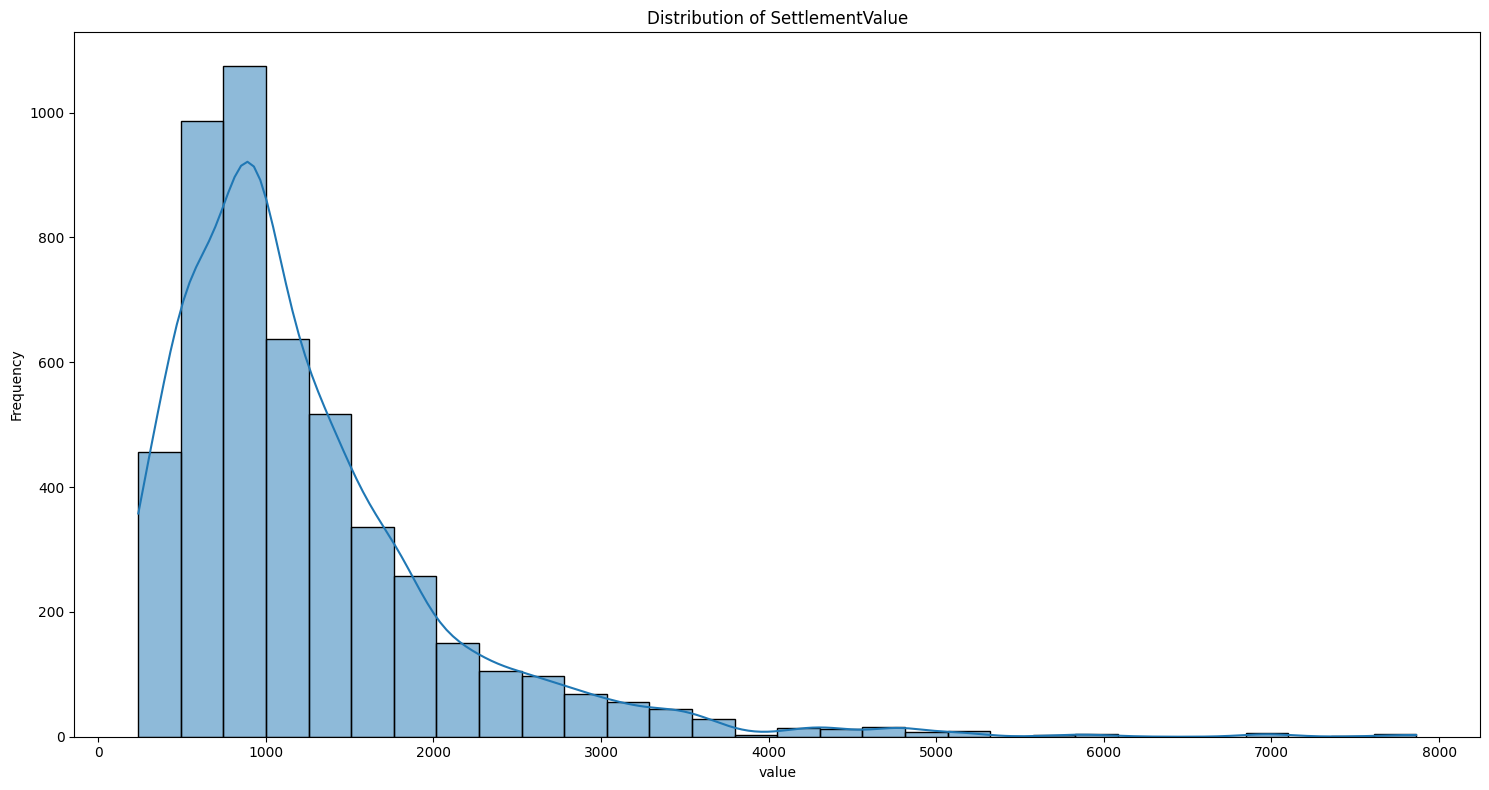

In [13]:
# visualize the distribution of target variable 'SettlementValue' using histogram
plt.figure(figsize=(15, 8))
sns.histplot(insurance_data['SettlementValue'], kde=True, bins=30) 
plt.title(f'Distribution of SettlementValue')
plt.xlabel('value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

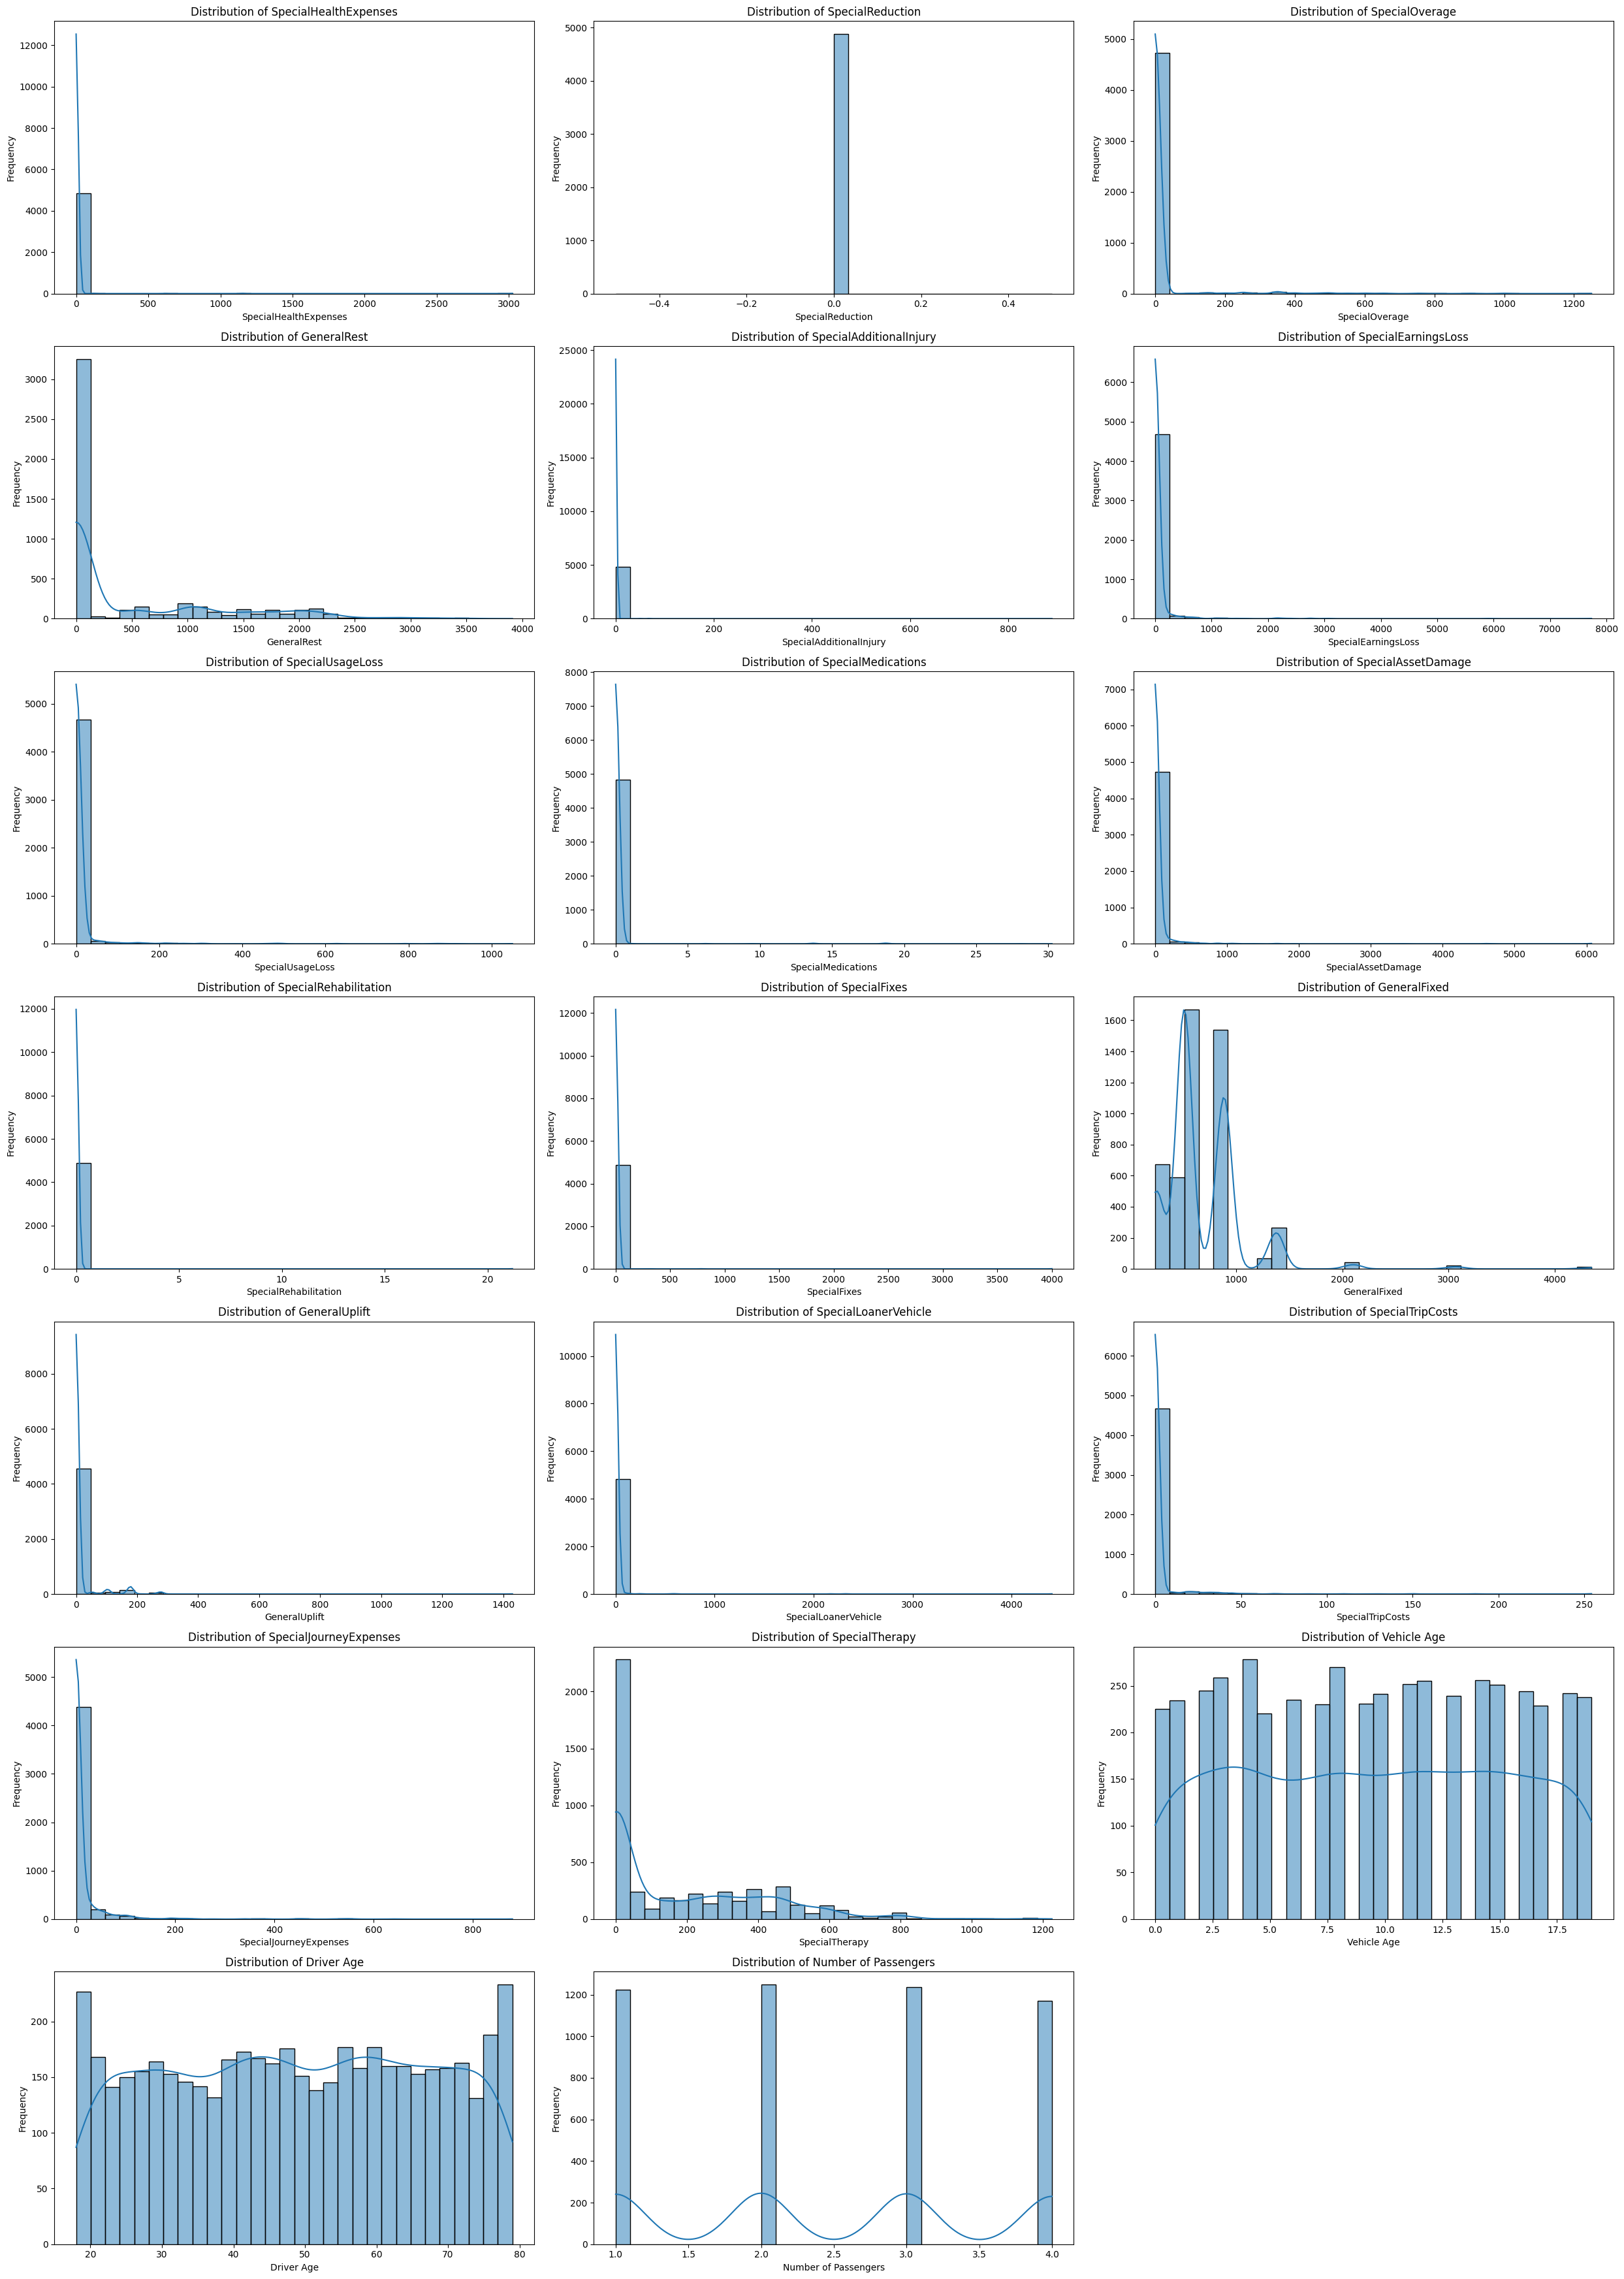

In [14]:
# visualize numerical input variables

numerical_data.drop('SettlementValue', axis=1, inplace=True) # drop the column of target variable

# Set up the figure and subplots
plt.figure(figsize=(25, 35))  # Adjust the figure size as needed
num_columns = len(numerical_data.columns)
rows = (num_columns // 3) + 1  # Adjust the number of rows based on the number of columns

# Loop through each numerical column and plot its distribution
for i, column in enumerate(numerical_data.columns, 1):
    plt.subplot(rows, 3, i)  # Create a subplot for each column
    sns.histplot(numerical_data[column], kde=True, bins=30)  # Plot histogram with KDE
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

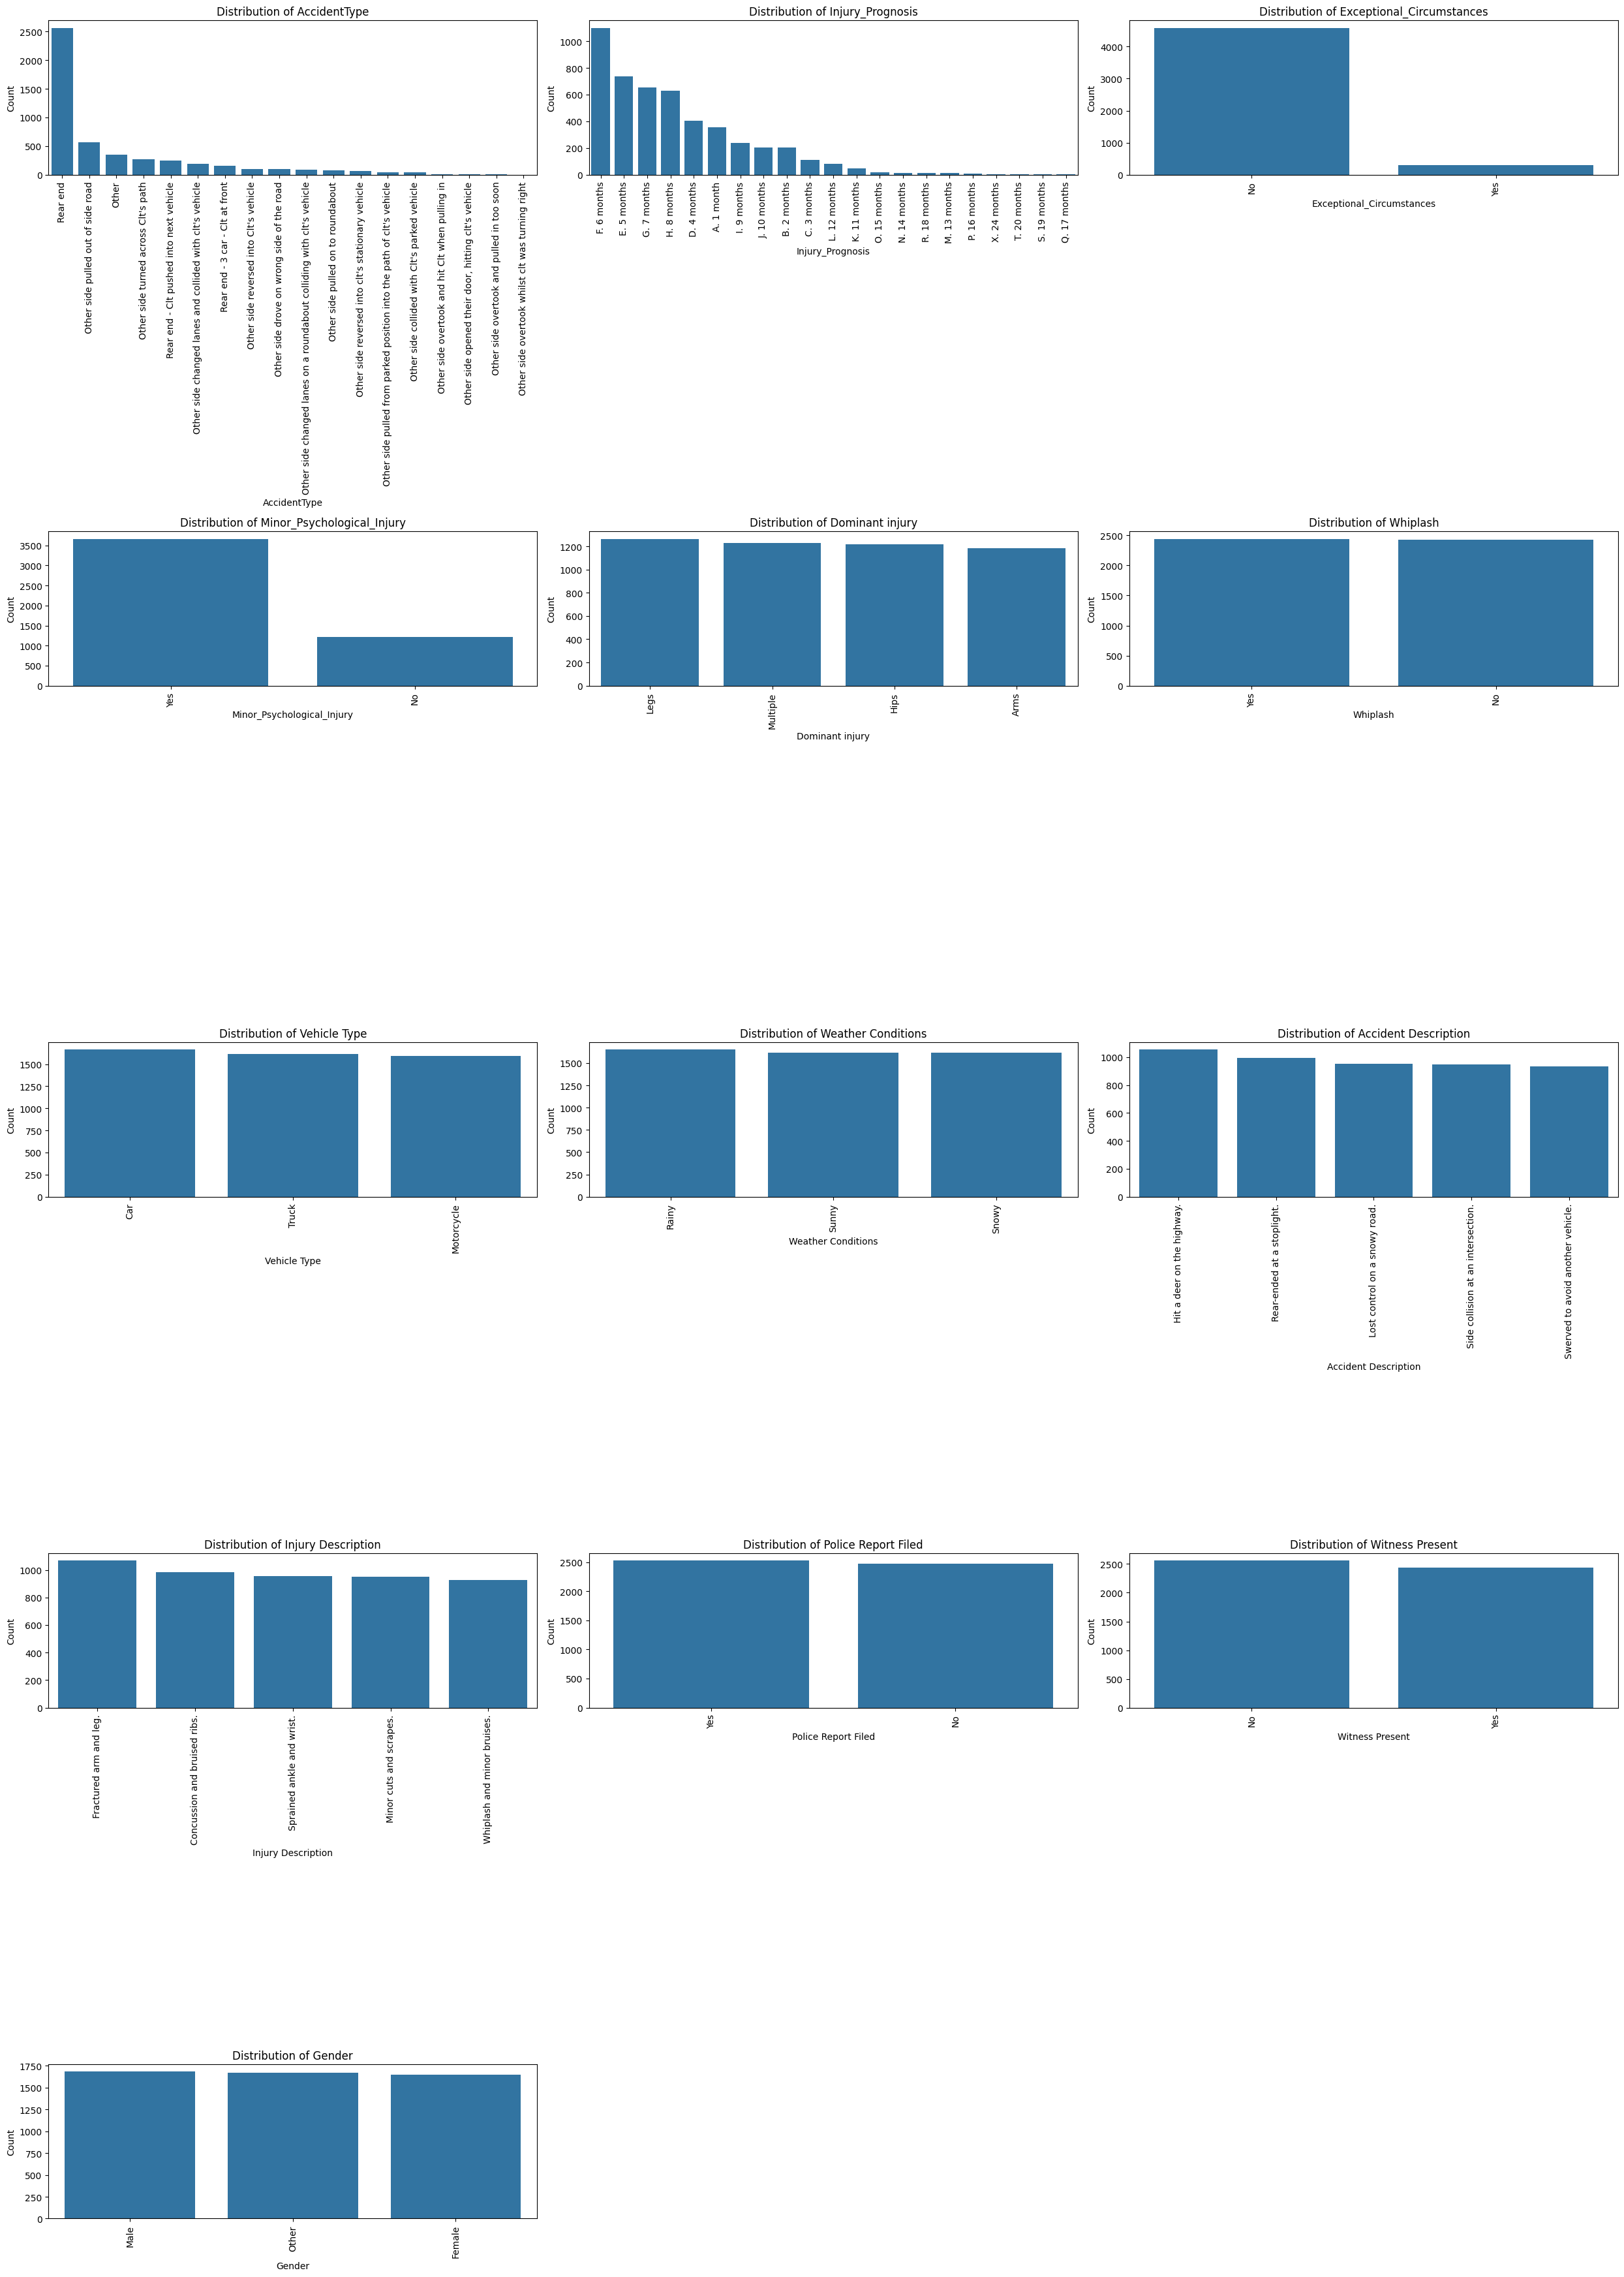

In [15]:
# visualize categorical input variables

plt.figure(figsize=(25, 35))  
num_columns = len(categorical_data.columns)
rows = (num_columns // 3) + 1  # Adjust the number of rows based on the number of columns

# Loop through each categorical column and plot its distribution
for i, column in enumerate(categorical_data.columns, 1):
    plt.subplot(rows, 3, i)  # Create a subplot for each column
    sns.countplot(x=categorical_data[column], order=categorical_data[column].value_counts().index)  # Plot bar plot
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

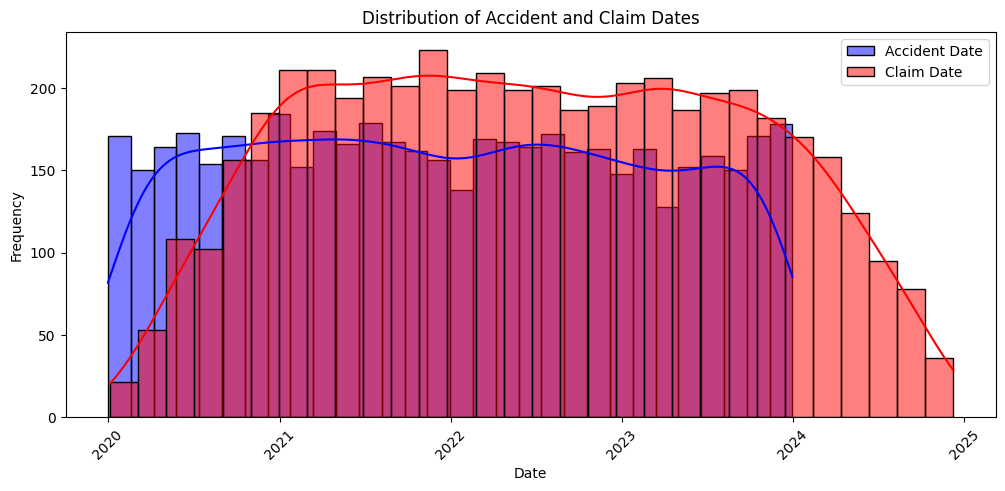

In [16]:
plt.figure(figsize=(12, 5))
sns.histplot(insurance_data["Accident Date"], bins=30, kde=True, color='blue', label="Accident Date")
sns.histplot(insurance_data["Claim Date"], bins=30, kde=True, color='red', label="Claim Date")

plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Distribution of Accident and Claim Dates")
plt.legend()
plt.xticks(rotation=45)
plt.show()


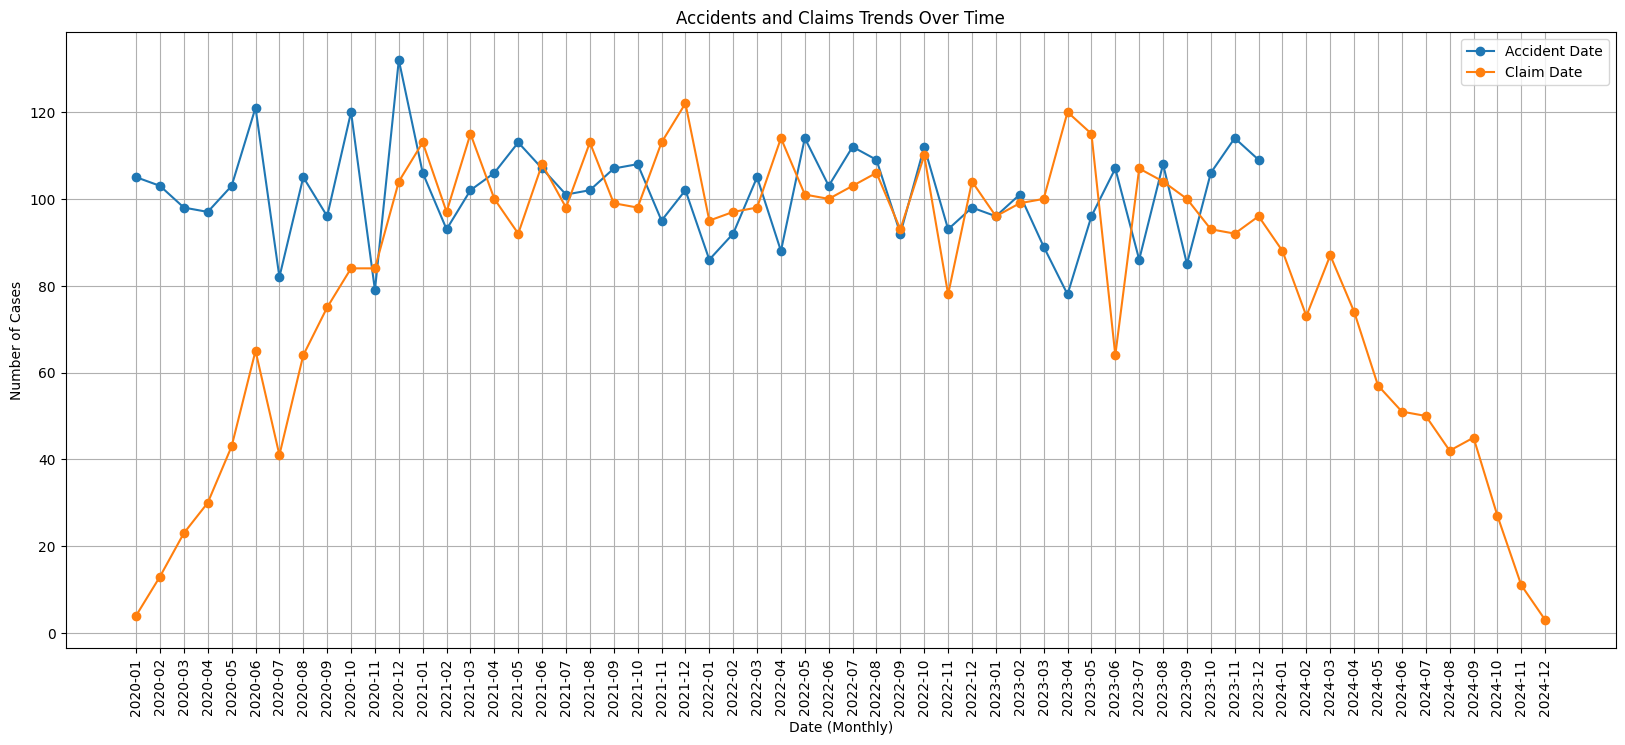

In [17]:
# visualization for date time data

# Count number of claims per month
accident = insurance_data.groupby(insurance_data["Accident Date"].dt.to_period("M")).size()
claim = insurance_data.groupby(insurance_data["Claim Date"].dt.to_period("M")).size()

# Plot
plt.figure(figsize=(20, 8))
plt.plot(accident.index.astype(str), accident, marker='o', label="Accident Date")
plt.plot(claim.index.astype(str), claim, marker='o', label="Claim Date")

plt.xlabel("Date (Monthly)")
plt.ylabel("Number of Cases")
plt.title("Accidents and Claims Trends Over Time")
plt.legend()
plt.xticks(rotation=90)
plt.grid()
plt.show()

### Outlier Analysis

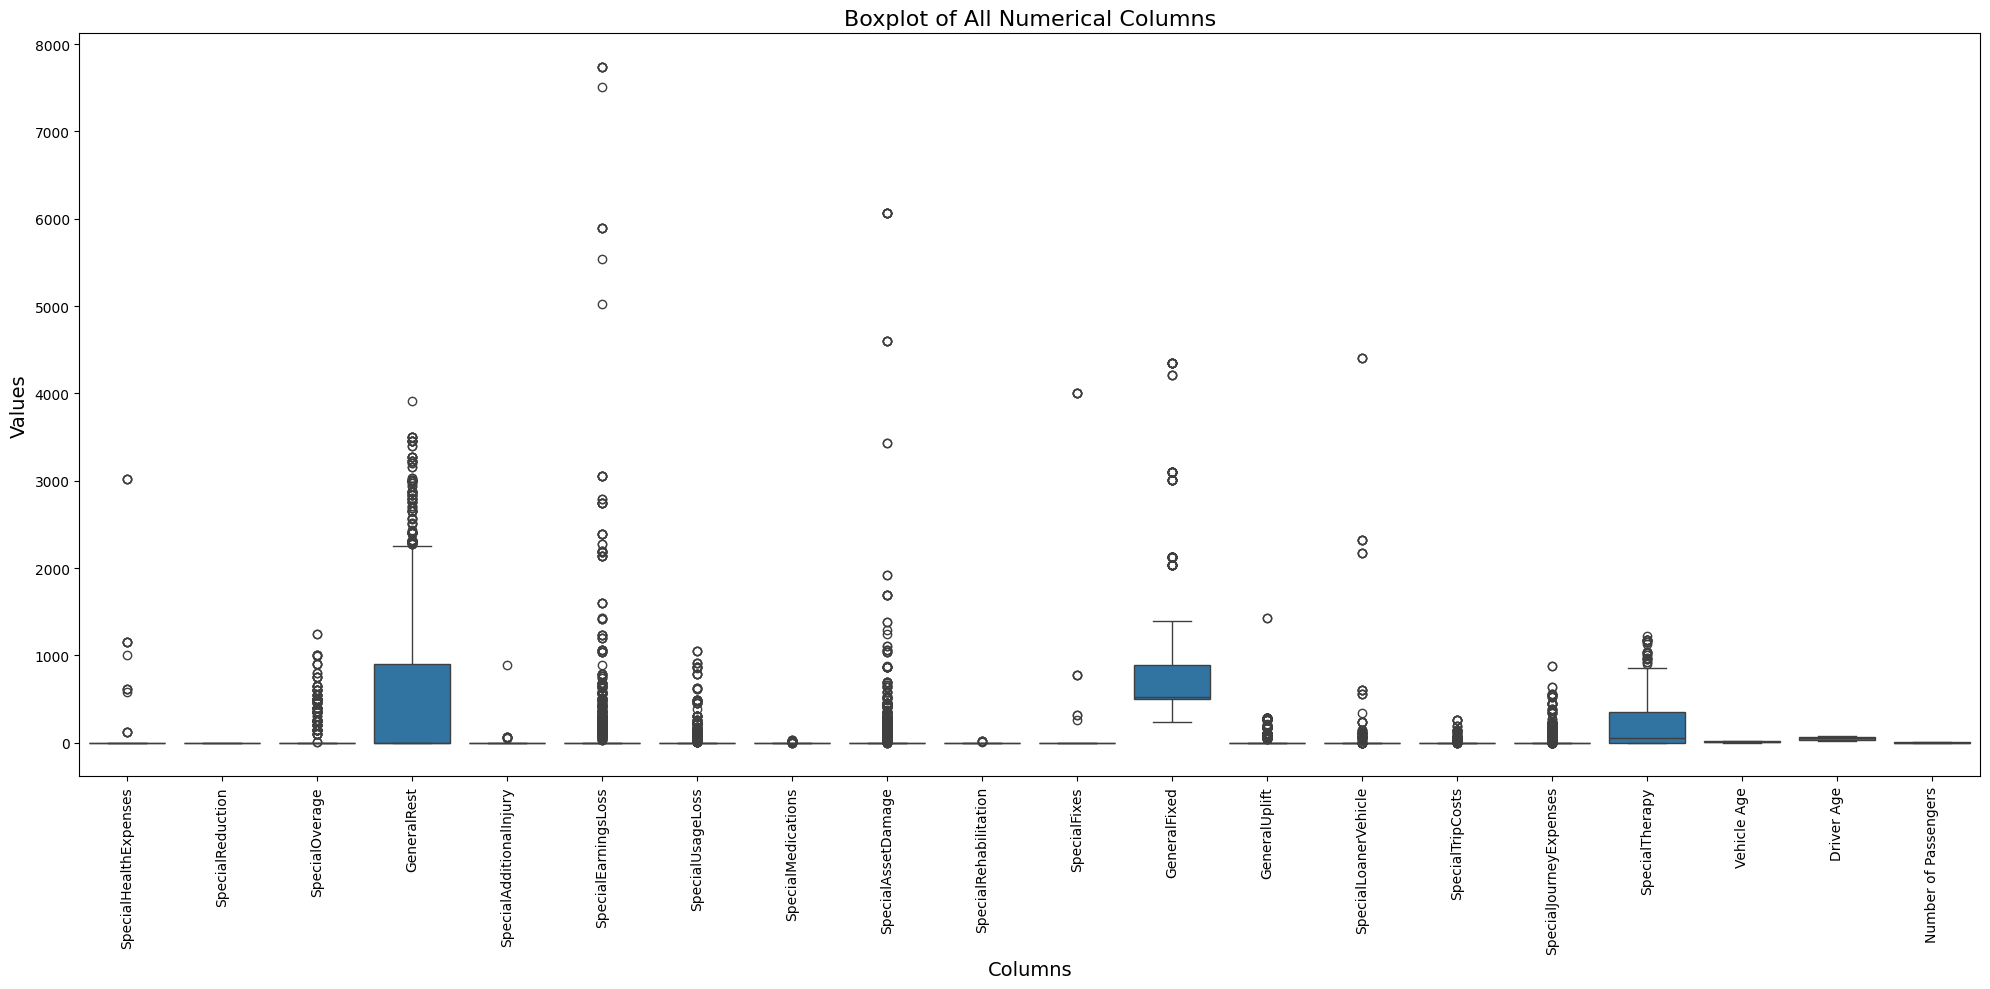

In [18]:
# visualize using boxplot

# Melt the DataFrame to long format for Seaborn
melted_data = numerical_data.melt(var_name='Columns', value_name='Values')

# Set up the figure
plt.figure(figsize=(20, 10))  # Adjust figure size for better readability

# Create a boxplot for all numerical columns
sns.boxplot(x='Columns', y='Values', data=melted_data)
plt.title('Boxplot of All Numerical Columns', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels vertically for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### Main Findings of EDA 

__Overall__
+ Although .shape returns 5000 instances x 36 features, many of the features have missing values
+ The dataset presents large amounts of object type data requiring further preprocessing to be used in ML Workflows
+ From the numerical data breakdown there is a feature ***SpecialReduction*** which contains a Min and Max of 0 which provides no insights
+ From boxplots and .desribe we can see that there is large differences between the distribution of the data. For Example
    + There may be some features with 1Q,2Q,3Q is 0 but 4Q is a very large number
    + This indicates large +ve skewness
    + May have to perform some type of data transformation

__Target Variable__
+ The target has 106 instances with NaN which is an issue 
+ The histogram plot shows -ve skewness in the data with most of the data concentrated around 1000 and below
+ The min, max and median is also spread far apart indicating a need for transformation or normalization

__Features__
+ The features analyzed are of object nature
+ Most features are either Yes or No questions
    + May consider using LabelEncoder or OneHotEncoder to replace with numerical data
    + Features such as ***Gender***, ***ExceptionalCircumstances*** among others
+ The ***Injury_prognosis*** feature although being an object can be truncated to form a numerical value.
+ May consider feature engineering techniques to enhance the correlation between ***AccidentDate*** , ***ClaimDate*** with ***SettlementValue***
    + May 






# Data Preprocessing

### Drop constant columns

In [19]:
# Drop the constant column 'SpecialReduction' from the dataset
insurance_data.drop('SpecialReduction', axis=1, inplace=True)

### Feature Engineering on Accident and Claim Date

In [20]:
# convert datetime columns into numerical values that the model can process
insurance_data['Days_Between_Accident_And_Claim'] = (insurance_data['Claim Date'] - insurance_data['Accident Date']).dt.days

In [21]:
# drop the datetime columns
insurance_data.drop(['Accident Date', 'Claim Date'], axis=1, inplace=True)

In [22]:
# fill the missing values with the median imputation
#insurance_data['Days_Between_Accident_And_Claim'] = insurance_data['Days_Between_Accident_And_Claim'].fillna(
#    insurance_data['Days_Between_Accident_And_Claim'].median()
#)

### Handle Missing Values

In [23]:
# Deleting missing values in target variable is preferable because imputation will result in bias in the model 
# Supervised learning models (such as regression) require known target values for training

# delete the rows of target variable 'SettlementValue' with missing values and impute the missing values in the input variables 
insurance_data.dropna(subset=['SettlementValue'], inplace=True)

In [24]:
# Impute numerical columns with median
numerical_data = insurance_data.select_dtypes(include=['float64']).columns
insurance_data[numerical_data] = insurance_data[numerical_data].fillna(insurance_data[numerical_data].median())

# Impute categorical columns with mode
categorical_data = insurance_data.select_dtypes(include=['object']).columns
insurance_data[categorical_data] = insurance_data[categorical_data].fillna(insurance_data[categorical_data].mode().iloc[0])

# Impute datetime columns with median
#datetime_data = insurance_data.select_dtypes(include=['datetime', 'datetime64']).columns
#insurance_data[datetime_data] = insurance_data[datetime_data].fillna(insurance_data[datetime_data].median())

In [25]:
insurance_data.isnull().sum()

SettlementValue                    0
AccidentType                       0
Injury_Prognosis                   0
SpecialHealthExpenses              0
SpecialOverage                     0
GeneralRest                        0
SpecialAdditionalInjury            0
SpecialEarningsLoss                0
SpecialUsageLoss                   0
SpecialMedications                 0
SpecialAssetDamage                 0
SpecialRehabilitation              0
SpecialFixes                       0
GeneralFixed                       0
GeneralUplift                      0
SpecialLoanerVehicle               0
SpecialTripCosts                   0
SpecialJourneyExpenses             0
SpecialTherapy                     0
Exceptional_Circumstances          0
Minor_Psychological_Injury         0
Dominant injury                    0
Whiplash                           0
Vehicle Type                       0
Weather Conditions                 0
Vehicle Age                        0
Driver Age                         0
N

### Truncating the ***Injury_Prognosis*** feature

In [26]:
# The number of months is a numeric value but is embedded within a string
# The letters (A, B, C...) are arbitrary and do not represent an inherent order, they should be removed

In [27]:
# Truncate and extract the numbers from Injury_Prognosis to form a float instead of object
insurance_data["Injury_Prognosis"] = insurance_data["Injury_Prognosis"].str.extract("(\d+)").astype(float)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\zheng\AppData\Local\Temp\ipykernel_8512\3991573653.py:2: SyntaxWarning: invalid escape sequence '\d'
  insurance_data["Injury_Prognosis"] = insurance_data["Injury_Prognosis"].str.extract("(\d+)").astype(float)


### Feature Encoding

In [28]:
## Clean dataset for the CatBoost Regressor without Data Encoding
unencoded_insurance_data = insurance_data

In [29]:
# label encoding 

label_encoding_cols = ['Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Whiplash', 'Police Report Filed', 'Witness Present']

label_encoder = LabelEncoder()

for col in label_encoding_cols:
    insurance_data[col] = label_encoder.fit_transform(insurance_data[col])

In [30]:
# one hot encoding

onehot_encoder = OneHotEncoder(sparse_output=False)

onehot_encoding_cols = ['Gender', 'Vehicle Type', 'Weather Conditions', 'Dominant injury']

# Fit and transform the selected columns
encoded_array = onehot_encoder.fit_transform(insurance_data[onehot_encoding_cols])

# Convert the encoded array to a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=onehot_encoder.get_feature_names_out(onehot_encoding_cols))

# Drop the original columns and concatenate with the encoded DataFrame
insurance_data = pd.concat([insurance_data.drop(columns=onehot_encoding_cols), encoded_df], axis=1)


In [31]:
# target encoding
# Features described above have too many categories and using LabelEncoder or OneHotEncoder would introduce bias and OneHotEncoder would increase dimensionality

target_encoding_cols = ['AccidentType', 'Accident Description', 'Injury Description']
target_column = 'SettlementValue'  # The target column for encoding

for col in target_encoding_cols:
    # Calculate the mean of the target variable for each category
    target_means = insurance_data.groupby(col)[target_column].mean()
    # Map the target means to the original column
    insurance_data[col] = insurance_data[col].map(target_means)

insurance_data.dropna(inplace=True)



In [32]:
insurance_data.isnull().sum()

SettlementValue                    0
AccidentType                       0
Injury_Prognosis                   0
SpecialHealthExpenses              0
SpecialOverage                     0
GeneralRest                        0
SpecialAdditionalInjury            0
SpecialEarningsLoss                0
SpecialUsageLoss                   0
SpecialMedications                 0
SpecialAssetDamage                 0
SpecialRehabilitation              0
SpecialFixes                       0
GeneralFixed                       0
GeneralUplift                      0
SpecialLoanerVehicle               0
SpecialTripCosts                   0
SpecialJourneyExpenses             0
SpecialTherapy                     0
Exceptional_Circumstances          0
Minor_Psychological_Injury         0
Whiplash                           0
Vehicle Age                        0
Driver Age                         0
Number of Passengers               0
Accident Description               0
Injury Description                 0
P

In [33]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4791 entries, 0 to 4893
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SettlementValue                  4791 non-null   float64
 1   AccidentType                     4791 non-null   float64
 2   Injury_Prognosis                 4791 non-null   float64
 3   SpecialHealthExpenses            4791 non-null   float64
 4   SpecialOverage                   4791 non-null   float64
 5   GeneralRest                      4791 non-null   float64
 6   SpecialAdditionalInjury          4791 non-null   float64
 7   SpecialEarningsLoss              4791 non-null   float64
 8   SpecialUsageLoss                 4791 non-null   float64
 9   SpecialMedications               4791 non-null   float64
 10  SpecialAssetDamage               4791 non-null   float64
 11  SpecialRehabilitation            4791 non-null   float64
 12  SpecialFixes             

# Feature Importance Analysis

### Correlation Analysis

<Axes: >

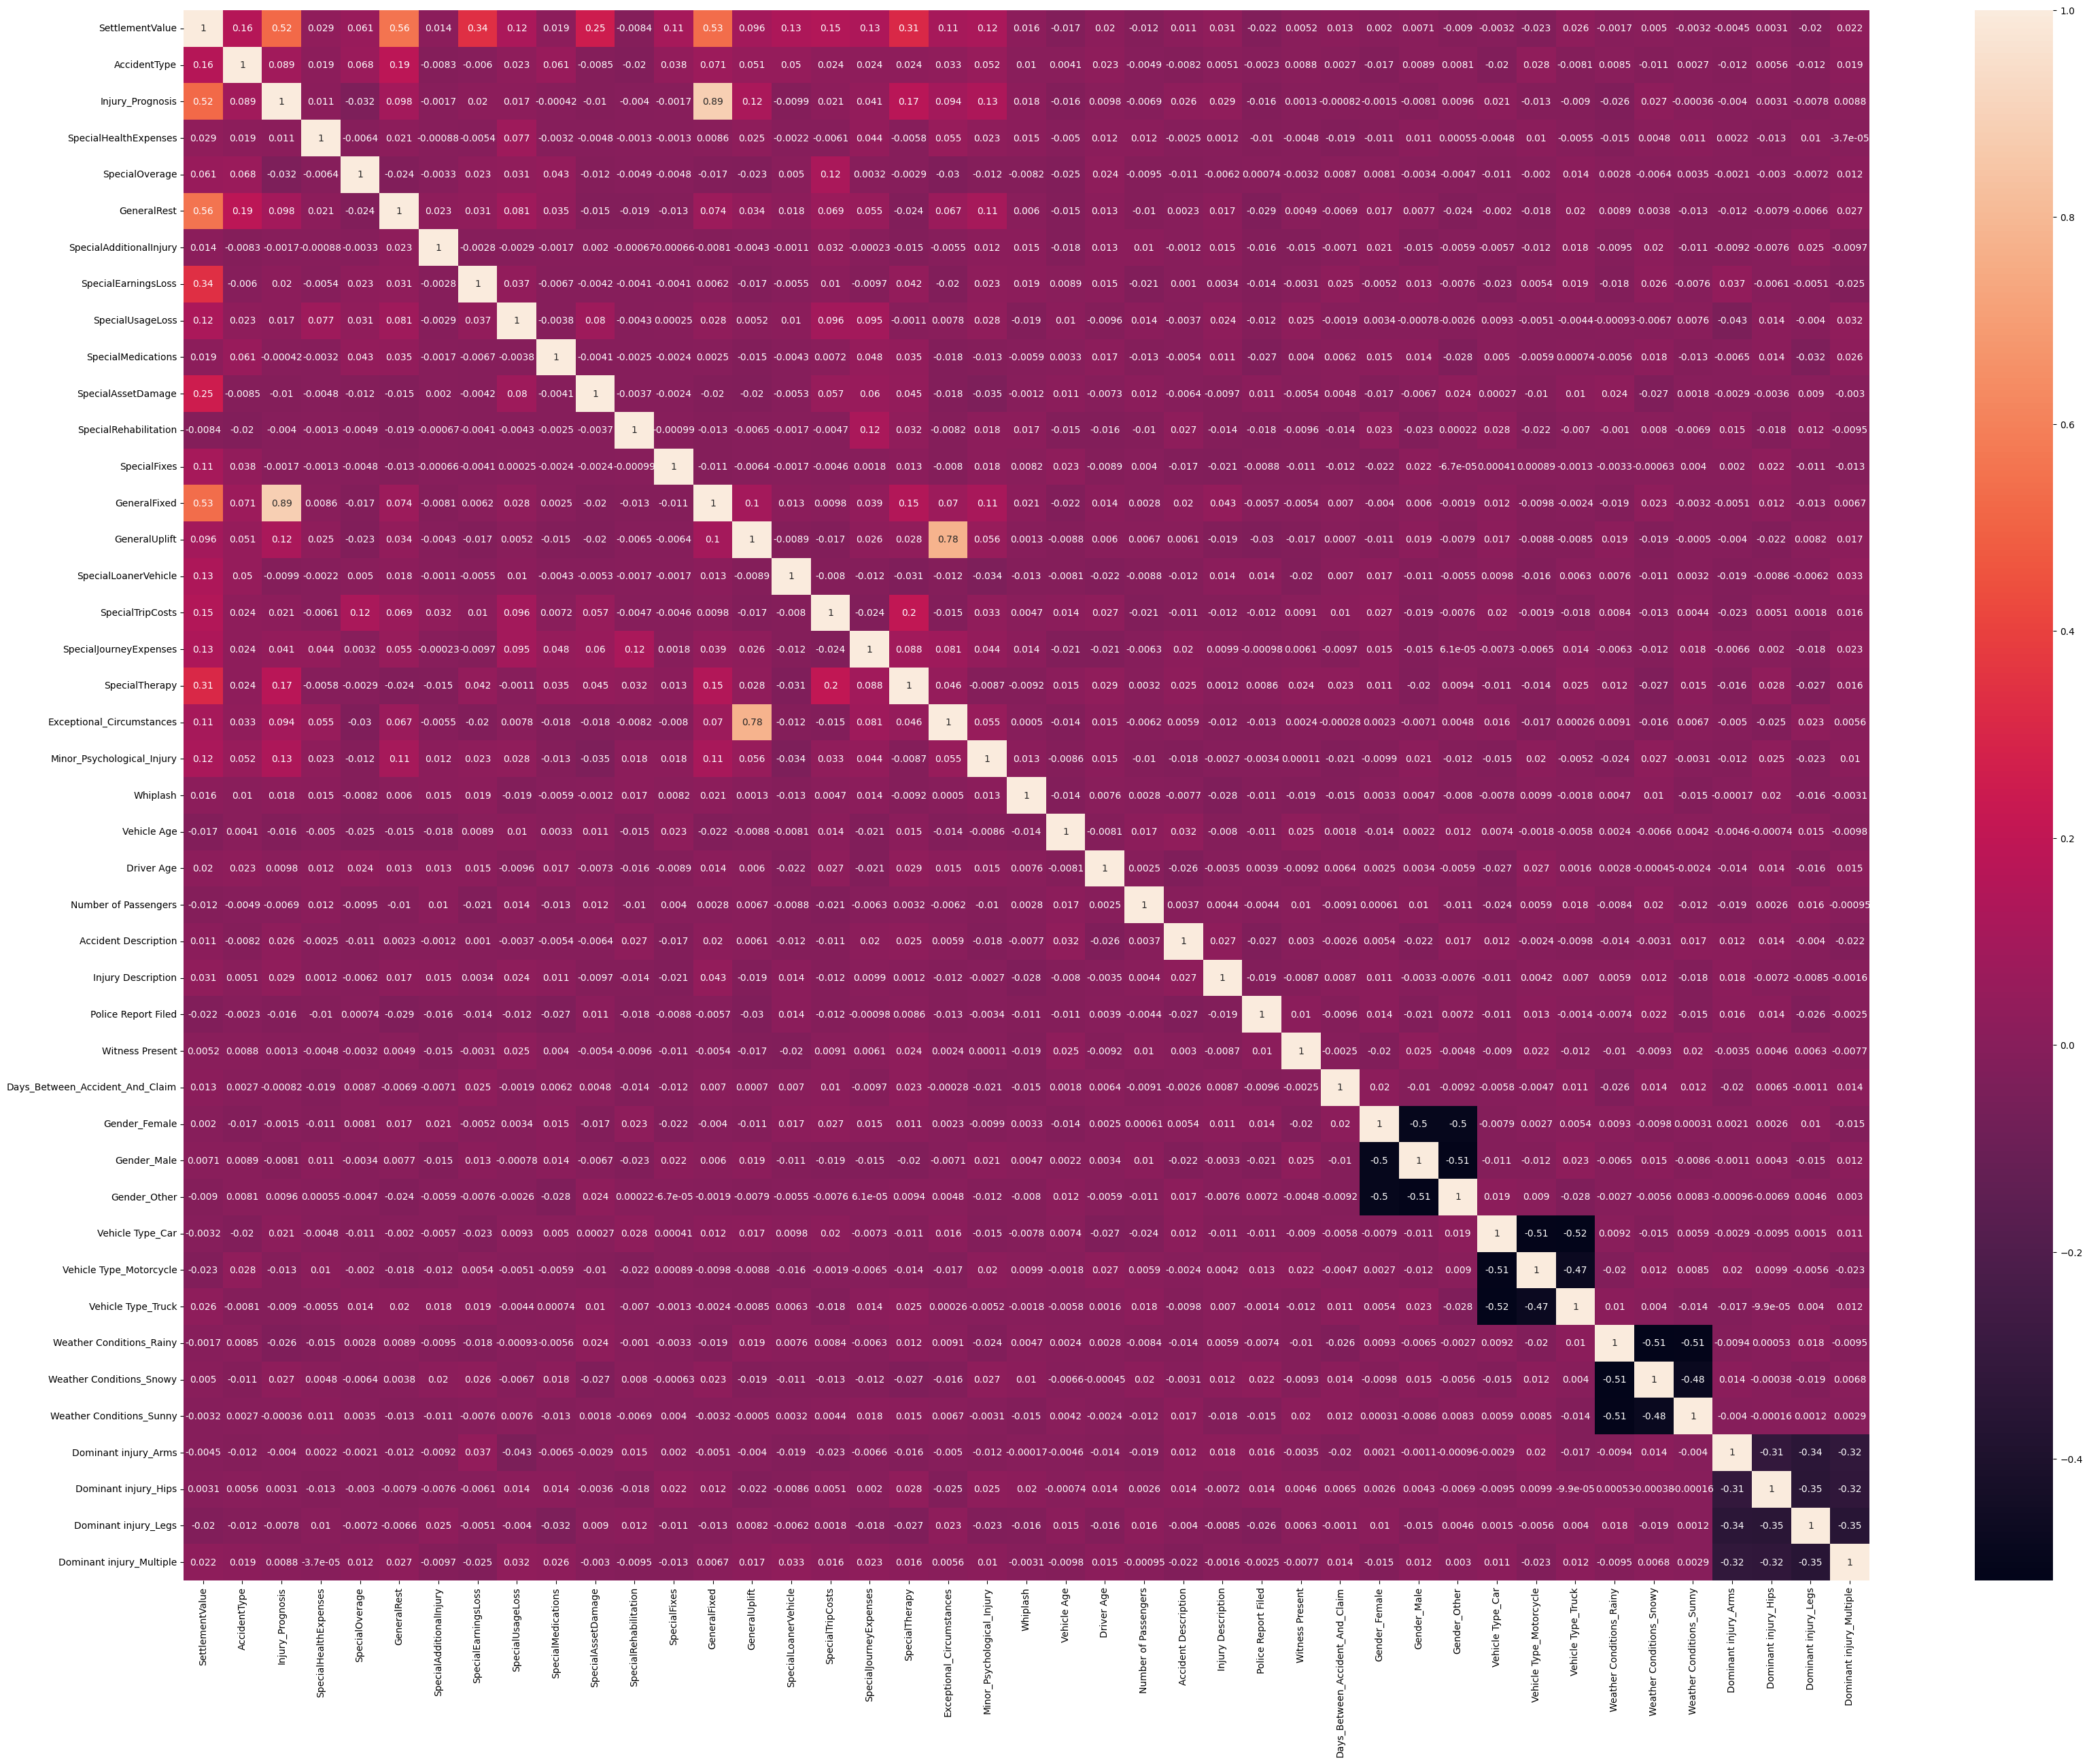

In [34]:
# Compute the correlation matrix
correlation_matrix = insurance_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True)

In [35]:
# Select Features with High Correlation

# Define the target variable
target = 'SettlementValue'

# Get the correlation of all features with the target variable
target_correlation = correlation_matrix[target]

# Define a threshold for high correlation
threshold = 0.05

# Select features with high correlation (positive or negative)
high_corr_features = target_correlation[(target_correlation.abs() > threshold)]

# Remove the target variable itself
if target in high_corr_features.index:
    high_corr_features.drop(target, inplace=True)

print("Features with high correlation to the target variable:")
print(high_corr_features)

Features with high correlation to the target variable:
AccidentType                  0.160473
Injury_Prognosis              0.520073
SpecialOverage                0.060683
GeneralRest                   0.557630
SpecialEarningsLoss           0.339237
SpecialUsageLoss              0.124345
SpecialAssetDamage            0.251348
SpecialFixes                  0.107982
GeneralFixed                  0.534579
GeneralUplift                 0.096187
SpecialLoanerVehicle          0.131317
SpecialTripCosts              0.150738
SpecialJourneyExpenses        0.130554
SpecialTherapy                0.312263
Exceptional_Circumstances     0.108039
Minor_Psychological_Injury    0.120263
Name: SettlementValue, dtype: float64


### Feature Importance with RandomForest Regressor

In [36]:
# create dataframe x and y to store selected features
x = insurance_data.drop(columns=['SettlementValue']) #select all features except target variable
y = insurance_data['SettlementValue'] #target variable

In [37]:
# perform train test split 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [38]:
# train a tree-based algorithm (random forest regressor) to calculate feature importance.
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

RandomForestRegressor()

In [39]:
# get the feature importance scores from the trained model
feature_importance = pd.DataFrame({'Features': X_train.columns, 'Importance': rf_regressor.feature_importances_}).sort_values(by='Importance', ascending=False)

Text(0.5, 1.0, 'Top 20 Important Features')

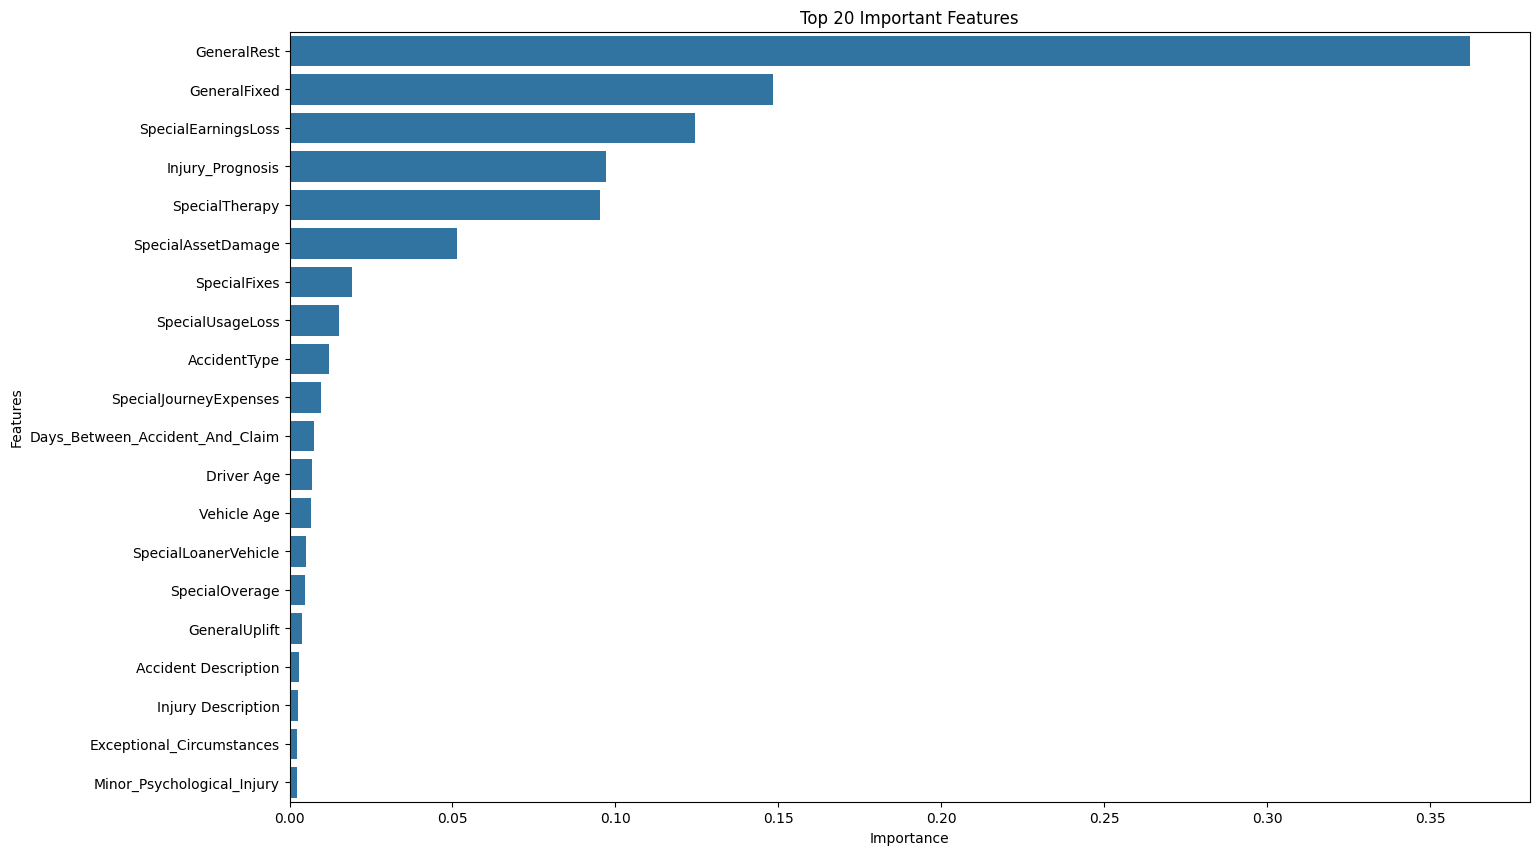

In [40]:
# visualize the importance by plotting the top features
plt.figure(figsize=(16, 10))
sns.barplot(x='Importance', y='Features', data=feature_importance.head(20))
plt.title('Top 20 Important Features')

In [41]:
# get the top 20 features
top_features = feature_importance['Features'][:20].values

# select the top 20 features from the training and testing data
X_train = X_train[top_features]
X_test = X_test[top_features]

In [42]:
# Check the columns of X_train
print("Columns of X_train:", X_train.columns.tolist())

# Check the columns of X_test
print("Columns of X_test:", X_test.columns.tolist())

Columns of X_train: ['GeneralRest', 'GeneralFixed', 'SpecialEarningsLoss', 'Injury_Prognosis', 'SpecialTherapy', 'SpecialAssetDamage', 'SpecialFixes', 'SpecialUsageLoss', 'AccidentType', 'SpecialJourneyExpenses', 'Days_Between_Accident_And_Claim', 'Driver Age', 'Vehicle Age', 'SpecialLoanerVehicle', 'SpecialOverage', 'GeneralUplift', 'Accident Description', 'Injury Description', 'Exceptional_Circumstances', 'Minor_Psychological_Injury']
Columns of X_test: ['GeneralRest', 'GeneralFixed', 'SpecialEarningsLoss', 'Injury_Prognosis', 'SpecialTherapy', 'SpecialAssetDamage', 'SpecialFixes', 'SpecialUsageLoss', 'AccidentType', 'SpecialJourneyExpenses', 'Days_Between_Accident_And_Claim', 'Driver Age', 'Vehicle Age', 'SpecialLoanerVehicle', 'SpecialOverage', 'GeneralUplift', 'Accident Description', 'Injury Description', 'Exceptional_Circumstances', 'Minor_Psychological_Injury']


### Train Test Split for Unencoded Dataframe (CatBoost Use Only!)

In [43]:
x_unencoded = unencoded_insurance_data.drop(columns=['SettlementValue']) #select all features except target variable
y_unencoded = unencoded_insurance_data['SettlementValue'] #target variable

In [44]:
X_train_unencoded, X_test_unencoded, y_train_unencoded, y_test_unencoded = train_test_split(x_unencoded, y_unencoded, test_size = 0.2, random_state = 42)

### Recursive Feature Elimination (RFE)

In [45]:
'''
# Apply Recursive Feature Elimination (RFE) to select the top 20 features
rfe = RFE(rf_regressor, n_features_to_select=20)
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = x.columns[rfe.support_]
selected_features
'''

'\n# Apply Recursive Feature Elimination (RFE) to select the top 20 features\nrfe = RFE(rf_regressor, n_features_to_select=20)\nrfe.fit(X_train, y_train)\n\n# Get selected feature names\nselected_features = x.columns[rfe.support_]\nselected_features\n'

### Findings on feature importance analysis

Based on the correlation heatmap and feature importance using RandomForestRegressor, we found that the GeneralFixed and GeneralRest are highly correlated with SettlementValue. 
SpecialEarningLoss, SpecialTherapy and SpecialAssetDamage also shows some level of correlation.

# Model Training

The algorithm used to predict the Settlement Value is Regression, this is because the Settlement Value is a continuous value. Below are the trained models with hyperparameter tuning. 

In this case, RandomSearch is mostly used to find the best hyperparameters for the models as it is more efficient than GridSearch in processing larger dataset. Although GridSearch is could find the most optimal combination of hyperparameters as it search all the possible combinations, it is more computationally expensive and may take a long time to run.

### Pre-training Preparation

In [46]:
# Feature Scaling using StandardScaler

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Convert scaled data back to DataFrame
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns, index=X_train.index)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns, index=X_test.index)

In [47]:
# Define function for hyperparameter tuning using RandomizedSearchCV

def randomsearch_tune(model, param_dist, X_train, y_train):

    random_search = RandomizedSearchCV(
        estimator = model,
        param_distributions = param_dist,
        n_iter = 100,
        cv = 5,
        scoring = "neg_mean_squared_error",
        n_jobs = -1,
        random_state = 42,
        verbose = 2
        #,error_score = 'raise'
    )
    
    random_search.fit(X_train, y_train)
    
    return random_search.best_estimator_, random_search.best_params_

In [48]:
# Define function for hyperparameter tuning using GridSearchCV

def gridsearch_tune(model, param_grid, X_train, y_train):

    grid_search = GridSearchCV(
        estimator = model,
        param_grid = param_grid,
        cv = 5,
        scoring = None,
        n_jobs = -1,
        verbose = 2
    )
    
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, grid_search.best_params_

### Linear Regression (Baseline)

In [48]:
# Initialize Linear Regression model
lr_model = LinearRegression()

# Train the model
lr = lr_model.fit(X_train, y_train)

# Make predictions
lr_y_pred = lr.predict(X_test)

### XGBoost Regressor

In [49]:
# Initialize XGBoost Regressor
xgb = XGBRegressor()

xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [50]:
# Define the hyperparameters of XGBoost Regressor
xgb_param_grid = {
    "n_estimators": [50, 100, 200, 300, 400, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10, 15],
    "min_child_weight": [1, 3, 5, 7, 10],
    "subsample": [0.5, 0.7, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1.0],
    "reg_lambda": [0, 1, 5, 10]
}

xgb_param_dist = {
    "n_estimators": randint(50, 500),
    "learning_rate": uniform(0.01, 0.2),
    "max_depth": randint(3, 15),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 10)
}

# Tune the XGBoost model
tuned_xgb, xgb_best_params = randomsearch_tune(xgb, xgb_param_dist, scaled_X_train, y_train)

# Display the best parameters
xgb_best_params


Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'colsample_bytree': 0.8484807311832108,
 'learning_rate': 0.20945110695367888,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 269,
 'reg_alpha': 0.9173956130855316,
 'reg_lambda': 0.05300006397605417,
 'subsample': 0.9875335814725712}

In [51]:
xgb_model = tuned_xgb.fit(scaled_X_train, y_train)

# Make predictions using the tuned model
xgb_y_pred = xgb_model.predict(scaled_X_test)

### Decision Tree Regressor

In [52]:
# Initialize decision tree regressor
dt = DecisionTreeRegressor()

dt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [53]:
# Define the hyperparameter grid for tuning
dt_param_grid = {
    "max_depth": [3, 5, 7, 9, 12, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", "log2", None],
    "splitter": ["best", "random"],
    "ccp_alpha": [0.0, 0.01, 0.05, 0.1],
    "max_leaf_nodes": [None, 10, 20, 50, 100]
}

# Tune the dt model
tuned_dt, dt_best_params = gridsearch_tune(dt, dt_param_grid, X_train, y_train)

# Display the best parameters
dt_best_params

Fitting 5 folds for each of 11520 candidates, totalling 57600 fits


{'ccp_alpha': 0.01,
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'splitter': 'random'}

In [54]:
# Make predictions
dt_y_pred = tuned_dt.predict(X_test)

### Random Forest Regressor

In [55]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor()

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [56]:
# Define the hyperparameter for tuning

rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at each leaf node
    'max_features': ['log2', 'sqrt', None]  # Number of features to consider at each split
}

rf_param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees
    'max_depth': randint(5, 20),          # Max depth of trees
    'min_samples_split': randint(2, 10),  # Min samples required to split a node
    'min_samples_leaf': randint(1, 10),   # Min samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Max features for split
    'bootstrap': [True, False],           # Whether bootstrap samples
    'criterion': ['squared_error', 'poisson'],  # Criterion for splitting
    'max_leaf_nodes': randint(10, 100),   # Max number of leaf nodes
}

# Perform RandomizedSearchCV
tuned_rf, rf_best_params = gridsearch_tune(rf, rf_param_grid, X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [57]:
rf_best_params

{'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [58]:
# Make predictions
rf_y_pred = tuned_rf.predict(X_test)

### MLP Regressor *!!!pending debug

In [59]:
# Initialize the MLP Regressor
mlp = MLPRegressor(max_iter=2000)

mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 2000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [60]:
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}
"""
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (100, 100, 50)],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [200, 500, 1000],
    'early_stopping': [True, False]'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (100, 100, 50)],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [200, 500, 1000],
    'early_stopping': [True, False]
"""                                                                                                                                 
mlp_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (100, 100, 50)],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': uniform(0.0001, 0.001),
    'alpha': uniform(0.0001, 0.1), 
    'max_iter': randint(200, 2000),
    'early_stopping': [True, False]
}

# Perform RandomizedSearchCV
tuned_mlp, mlp_best_params = randomsearch_tune(mlp, mlp_param_dist, scaled_X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\t2-zhengshen\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
48 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\t2-zhengshen\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\t2-zhengshen\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\t2-zhengshen\AppData\Ro

In [61]:
# Make predictions
mlp_y_pred = tuned_mlp.predict(scaled_X_test)

In [62]:
mlp_model = mlp.fit(scaled_X_train, y_train)
mlp_predict = mlp_model.predict(scaled_X_test)

C:\Users\t2-zhengshen\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Support Vector Regressor

In [63]:
# initialize the SVR model
svr = SVR()

svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [64]:
# Define the hyperparameter grid for tuning
svr_param_grid = {
    'C': [0.1, 1, 10, 100],  
    'epsilon': [0.01, 0.1, 0.5, 1],  
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  
    'degree': [2, 3, 4]  # Only relevant if kernel='poly'
}

svr_param_dist = {
    'C': [0.1, 1, 10, 100], 
    'epsilon': [0.01, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
    'kernel': ['linear', 'rbf'],  
    'shrinking': [True] 
}

"""
    'C': uniform(0.1, 100),  # Regularization parameter C
    'epsilon': uniform(0.01, 1.0),  # Epsilon, controlling the width of the margin
    'gamma': ['scale', 'auto'] + list(uniform(0.001, 1.0).rvs(10)),  # Gamma values
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types to try
    'shrinking': [True, False]  # Use shrinking heuristic for speed
"""

# Initialize Grid Search
tuned_svr, svr_best_params = randomsearch_tune(svr, svr_param_dist, scaled_X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [65]:
# Make predictions
svr_y_pred = tuned_svr.predict(scaled_X_test)

In [66]:
svr_model = svr.fit(scaled_X_train, y_train)
svr_predict = svr_model.predict(scaled_X_test)

### Gradient Boosting Regressor

In [67]:
# Initialize the model
gbr = GradientBoostingRegressor(random_state=42)

gbr.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [68]:
# Define the hyperparameter grid for tuning
gbr_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize Random Search
tuned_gbr, gbr_best_params = randomsearch_tune(gbr, gbr_param_grid, X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [69]:
print(gbr_best_params)

{'subsample': 1.0, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.2}


In [70]:
# Make predictions
gbr_y_pred = tuned_gbr.predict(X_test)

### K Neighbours Regressor 

In [71]:
knr = KNeighborsRegressor()
knr.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [72]:
# Define the parameter grid
knr_param_dist = {
    'n_neighbors': range(1, 21),  # or range(1, 31)
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(10, 100, 10),
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'p': [1, 2],
    'n_jobs': [-1]
}

# Perform RandomizedSearchCV
tuned_knr, knr_best_params = randomsearch_tune(knr, knr_param_dist, scaled_X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [73]:
knr_y_pred = tuned_knr.predict(scaled_X_test)

### CatBoost Regressor 

#### Encoded Dataframe

In [74]:
catBoost =  CatBoostRegressor()
catBoost.get_params()

{'loss_function': 'RMSE'}

In [75]:
catboost_param_dist = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0.1, 0.5, 1.0],
    'random_strength': [1, 2, 3],
}

tuned_catBoost, catboost_best_params = randomsearch_tune(catBoost, catboost_param_dist, X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0:	learn: 807.6950982	total: 91.9ms	remaining: 27.5s
1:	learn: 761.3310668	total: 93.4ms	remaining: 13.9s
2:	learn: 716.7855122	total: 94.9ms	remaining: 9.39s
3:	learn: 681.4507650	total: 96.5ms	remaining: 7.14s
4:	learn: 645.6724335	total: 98ms	remaining: 5.78s
5:	learn: 617.5060789	total: 99.7ms	remaining: 4.89s
6:	learn: 588.9418408	total: 101ms	remaining: 4.24s
7:	learn: 564.7600616	total: 103ms	remaining: 3.76s
8:	learn: 538.9521048	total: 104ms	remaining: 3.38s
9:	learn: 517.5991222	total: 106ms	remaining: 3.07s
10:	learn: 498.8275627	total: 107ms	remaining: 2.82s
11:	learn: 481.7709931	total: 109ms	remaining: 2.62s
12:	learn: 466.6515809	total: 110ms	remaining: 2.44s
13:	learn: 453.0337380	total: 112ms	remaining: 2.29s
14:	learn: 438.6830424	total: 113ms	remaining: 2.15s
15:	learn: 426.2916387	total: 115ms	remaining: 2.04s
16:	learn: 416.7433936	total: 116ms	remaining: 1.94s
17:	learn: 407.0646723	total: 118ms	remain

In [76]:
catBoost_model = tuned_catBoost.fit(X_train, y_train)
catBoost_y_pred = catBoost_model.predict(X_test)

0:	learn: 807.6950982	total: 1.87ms	remaining: 560ms
1:	learn: 761.3310668	total: 3.35ms	remaining: 499ms
2:	learn: 716.7855122	total: 5.12ms	remaining: 507ms
3:	learn: 681.4507650	total: 6.59ms	remaining: 488ms
4:	learn: 645.6724335	total: 8.11ms	remaining: 479ms
5:	learn: 617.5060789	total: 9.51ms	remaining: 466ms
6:	learn: 588.9418408	total: 11.1ms	remaining: 465ms
7:	learn: 564.7600616	total: 12.7ms	remaining: 462ms
8:	learn: 538.9521048	total: 14.1ms	remaining: 457ms
9:	learn: 517.5991222	total: 15.7ms	remaining: 455ms
10:	learn: 498.8275627	total: 17.1ms	remaining: 450ms
11:	learn: 481.7709931	total: 18.6ms	remaining: 447ms
12:	learn: 466.6515809	total: 20.3ms	remaining: 449ms
13:	learn: 453.0337380	total: 21.8ms	remaining: 445ms
14:	learn: 438.6830424	total: 23.2ms	remaining: 440ms
15:	learn: 426.2916387	total: 24.5ms	remaining: 435ms
16:	learn: 416.7433936	total: 26ms	remaining: 433ms
17:	learn: 407.0646723	total: 27.4ms	remaining: 429ms
18:	learn: 397.9701498	total: 28.7ms	rem

In [77]:
print(catboost_best_params)

{'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8, 'border_count': 64, 'bagging_temperature': 0.5}


#### Unencoded Dataframe

In [78]:
catboost_unencoded = CatBoostRegressor(cat_features=['AccidentType', 'Exceptional_Circumstances', 'Minor_Psychological_Injury',
                                         'Dominant injury', 'Vehicle Type', 'Weather Conditions', 'Whiplash', 
                                         'Accident Description', 'Injury Description', 'Gender', 
                                         'Police Report Filed', 'Witness Present'], 
                           verbose=0)
catboost_param_dist = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0.1, 0.5, 1.0],
    'random_strength': [1, 2, 3],
}
unencoded_tuned_catBoost, unencoded_catboost_best_params = randomsearch_tune(catboost_unencoded, catboost_param_dist, X_train_unencoded, y_train_unencoded)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [79]:
print(unencoded_catboost_best_params)

{'random_strength': 3, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6, 'border_count': 128, 'bagging_temperature': 1.0}


In [80]:
unencoded_catBoost_model = unencoded_tuned_catBoost.fit(X_train_unencoded, y_train_unencoded)
unencoded_catBoost_y_pred = unencoded_catBoost_model.predict(X_test_unencoded)

### ADABoost Regressor

In [81]:
adaboost = AdaBoostRegressor()
adaboost.get_params()

{'estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': None}

In [82]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'loss': ['linear', 'square', 'exponential'],
}

tuned_adaboost, adaboost_best_params = randomsearch_tune(adaboost, adaboost_param_grid, X_train, y_train)
adaboost_y_pred = tuned_adaboost.predict(X_test)

C:\Users\t2-zhengshen\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits


### Light Gradient Boosting Regressor

In [83]:
lgbm = LGBMRegressor()

lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [84]:
lgbm_model = lgbm.fit(scaled_X_train, y_train)

lgbm_predict = lgbm_model.predict(scaled_X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1225
[LightGBM] [Info] Number of data points in the train set: 3832, number of used features: 19
[LightGBM] [Info] Start training from score 1221.288828


In [85]:
lgbm_param_dist = {
    'n_estimators': np.arange(50, 500, 50),  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'max_depth': np.arange(3, 10),  # Maximum depth of trees
    'num_leaves': np.arange(20, 100, 10),  # Maximum number of leaves
    'min_child_samples': np.arange(10, 50, 10),  # Minimum data in a leaf
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio
    'colsample_bytree': [0.6, 0.8, 1.0],  # Feature subsample ratio
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5],  # L2 regularization
}

# Perform RandomizedSearchCV
tuned_lgbm, lgbm_best_params = randomsearch_tune(lgbm, lgbm_param_dist, scaled_X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1225
[LightGBM] [Info] Number of data points in the train set: 3832, number of used features: 19
[LightGBM] [Info] Start training from score 1221.288828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [86]:
# Print the best parameters from LGBM RandomizedSearchCV
print("Best parameters for LightGBM model:")
print(lgbm_best_params)

# Create a DataFrame to display the parameters in a nice format
best_params_df = pd.DataFrame({
    'Parameter': lgbm_best_params.keys(),
    'Value': lgbm_best_params.values()
})

# Display the DataFrame
best_params_df

Best parameters for LightGBM model:
{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': 30, 'n_estimators': 450, 'min_child_samples': 10, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


,Parameter,Value
0,subsample,0.8
1,reg_lambda,0.1
2,reg_alpha,0.0
3,num_leaves,30.0
4,n_estimators,450.0
5,min_child_samples,10.0
6,max_depth,8.0
7,learning_rate,0.1
8,colsample_bytree,0.6


In [87]:
lgbm_y_pred = tuned_lgbm.predict(scaled_X_test)

### Multi-Layered Perceptron (MLP)

In [88]:
# Build a MLP model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")

# Make predictions
y_pred = model.predict(X_test)

Epoch 1/100


C:\Users\t2-zhengshen\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 956772.5000 - mean_absolute_error: 663.2223 - val_loss: 206212.5000 - val_mean_absolute_error: 262.6609
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 172321.3281 - mean_absolute_error: 241.3167 - val_loss: 204994.2344 - val_mean_absolute_error: 228.9261
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121812.2109 - mean_absolute_error: 211.6212 - val_loss: 202637.0625 - val_mean_absolute_error: 220.6129
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122824.1094 - mean_absolute_error: 208.0065 - val_loss: 211496.0938 - val_mean_absolute_error: 230.8328
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109997.4219 - mean_absolute_error: 196.2602 - val_loss: 207118.8281 - val_mean_absolute_error: 252.9110
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122663.5078 - mean_absolute_error: 207.2812 - val_loss: 211083.2500 - val_mean_absolute_error: 221.7102
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━

### Deep Neural Network (DNN)

In [89]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='elu'))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(48, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
optimizer = Adam(learning_rate=0.00085)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
# Early stopping
early_stopping = EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=200,batch_size=48, validation_split=0.2)

# Evaluate model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")
print(f"Test RMSE: {np.sqrt(loss)}")
print(f"Test R²: {r2_score(y_test, model.predict(X_test))}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, model.predict(X_test))}")
# Make predictions
ann_y_pred = model.predict(X_test)

Epoch 1/200


C:\Users\t2-zhengshen\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1156561.8750 - mae: 762.6871 - val_loss: 224943.0625 - val_mae: 248.3964
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132937.3438 - mae: 228.4934 - val_loss: 200057.2344 - val_mae: 226.9900
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123671.4219 - mae: 217.6380 - val_loss: 198231.8281 - val_mae: 223.3346
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130438.5859 - mae: 204.7630 - val_loss: 219045.2188 - val_mae: 214.2657
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117148.2578 - mae: 198.7537 - val_loss: 207932.6875 - val_mae: 214.3406
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117687.1953 - mae: 198.2236 - val_loss: 199476.3750 - val_mae: 220.6084
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135694.1875 - mae: 216.7257 - val_loss: 203178.3906 - val_mae: 211.2396
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118395.7734 - mae: 201.0676 - val_l

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Function to create the model with hyperparameters
def create_model(hidden_layers=2, neurons=64, activation='relu', dropout_rate=0.2, learning_rate=0.001, optimizer='adam'):
    model = Sequential()
    
    # Input layer
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    # Compile model with selected optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = RMSprop(learning_rate=learning_rate)
        
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
    
    return model

# Create the KerasRegressor
keras_model = KerasRegressor(
    model=create_model,
    epochs=100,
    batch_size=32,
    verbose=0
)

# Define the hyperparameter space
param_distributions = {
    'hidden_layers': [1, 2, 3, 4],
    'neurons': [32, 64, 128, 256],
    'activation': ['relu', 'elu', 'selu'],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4],
    'learning_rate': [0.0001, 0.001, 0.01],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=keras_model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    cv=3,       # Cross-validation folds
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=1,   # Adjust based on your CPU
    random_state=42
)

# Early stopping callback to add during fitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Fit the model
random_search.fit(
    scaled_X_train, 
    y_train, 
    callbacks=[early_stopping],
    validation_split=0.2
)

# Print results
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Train the best model
best_dnn = random_search.best_estimator_
best_dnn_y_pred = best_dnn.predict(scaled_X_test)

# Evaluate model performance
dnn_mse = mean_squared_error(y_test, best_dnn_y_pred)
dnn_rmse = np.sqrt(dnn_mse)
dnn_mae = mean_absolute_error(y_test, best_dnn_y_pred)
dnn_r2 = r2_score(y_test, best_dnn_y_pred)

print(f"Best DNN Model Performance:")
print(f"MSE: {dnn_mse:.2f}")
print(f"RMSE: {dnn_rmse:.2f}")
print(f"MAE: {dnn_mae:.2f}")
print(f"R²: {dnn_r2:.2f}")

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
"""class CustomKerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model=None, **kwargs):
        self.model = model
        self.kwargs = kwargs

    def fit(self, X, y, **kwargs):
        # Ensure data is in the correct format
        X, y = check_array(X), check_array(y)
        
        # Create the Keras model and fit it
        self.model = self.model(**self.kwargs)
        self.model.fit(X, y, **kwargs)
        return self
    
    def predict(self, X):
        X = check_array(X)
        return self.model.predict(X)

    def get_params(self, deep=True):
        return self.kwargs

    def set_params(self, **params):
        self.kwargs.update(params)
        return self"""

### GBM Ensemble Model 

In [90]:
## Meta Learner : LightGBM Regressor 
## Stacking Ensemble : Random Forest Regressor, XGBoost Regressor and CatBoost Regressor 
## RF Params : {'max_depth': None, 'max_features': None,'min_samples_leaf': 1,'min_samples_split': 2,'n_estimators': 200}
## LGBM Params : {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': np.int64(30), 'n_estimators': np.int64(450), 'min_child_samples': np.int64(10), 'max_depth': np.int64(8), 'learning_rate': 0.1, 'colsample_bytree': 0.6}
## XGB Params : {'colsample_bytree': np.float64(0.8484807311832108),'learning_rate': np.float64(0.20945110695367888),'max_depth': 8,'min_child_weight': 2, 'n_estimators': 269, 'reg_alpha': np.float64(0.9173956130855316),'reg_lambda': np.float64(0.05300006397605417),'subsample': np.float64(0.9875335814725712)}
## Catboost Params : {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8, 'border_count': 64, 'bagging_temperature': 0.5}

In [91]:
# Define the base models
gbm = GradientBoostingRegressor(subsample = 0.9, n_estimators = 300, min_samples_split = 10, min_samples_leaf = 1, max_features = None, max_depth = 5, learning_rate = 0.1)
rf = RandomForestRegressor(max_depth = None, max_features = None,min_samples_leaf = 1,min_samples_split = 2, n_estimators = 200)
xgb = XGBRegressor(colsample_bytree = np.float64(0.8484807311832108),learning_rate = np.float64(0.20945110695367888),max_depth= 8,min_child_weight =2, n_estimators = 269, reg_alpha = np.float64(0.9173956130855316),reg_lambda = np.float64(0.05300006397605417),subsample = np.float64(0.9875335814725712))
cat = CatBoostRegressor(random_strength = 1, learning_rate = 0.1, l2_leaf_reg = 1, iterations = 300, depth = 8, border_count = 64, bagging_temperature = 0.5)
lgbm = LGBMRegressor(subsample = 0.8, reg_lambda = 0.1, reg_alpha = 0, num_leaves = np.int64(30), n_estimators = np.int64(450), min_child_samples = np.int64(10), max_depth = np.int64(8), learning_rate = 0.1, colsample_bytree = 0.6)

# Define the meta learner
meta_learner = gbm

# Define the stacking ensemble
estimators = [('rf', rf), ('xgb', xgb), ('cat', cat)]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=meta_learner, cv=10)

# Train the stacking ensemble
stacking_regressor.fit(X_train, y_train)

# Make predictions
stacking_y_pred = stacking_regressor.predict(X_test)

0:	learn: 807.6950982	total: 2.07ms	remaining: 619ms
1:	learn: 761.3310668	total: 3.88ms	remaining: 578ms
2:	learn: 716.7855122	total: 5.4ms	remaining: 535ms
3:	learn: 681.4507650	total: 6.86ms	remaining: 507ms
4:	learn: 645.6724335	total: 8.38ms	remaining: 494ms
5:	learn: 617.5060789	total: 9.91ms	remaining: 486ms
6:	learn: 588.9418408	total: 11.5ms	remaining: 481ms
7:	learn: 564.7600616	total: 13ms	remaining: 474ms
8:	learn: 538.9521048	total: 14.5ms	remaining: 467ms
9:	learn: 517.5991222	total: 16ms	remaining: 463ms
10:	learn: 498.8275627	total: 17.5ms	remaining: 459ms
11:	learn: 481.7709931	total: 18.9ms	remaining: 454ms
12:	learn: 466.6515809	total: 20.6ms	remaining: 455ms
13:	learn: 453.0337380	total: 22.2ms	remaining: 453ms
14:	learn: 438.6830424	total: 23.6ms	remaining: 449ms
15:	learn: 426.2916387	total: 25.3ms	remaining: 448ms
16:	learn: 416.7433936	total: 26.8ms	remaining: 446ms
17:	learn: 407.0646723	total: 28.3ms	remaining: 443ms
18:	learn: 397.9701498	total: 29.9ms	remain

In [92]:
## DO NOT UNCOMMENT TAKES ABOUT 2 HOURS TO RUN 
"""
# List of potential meta-learners
meta_learners = [gbm,rf,xgb,cat,lgbm]

# Create a dictionary to store performance scores
meta_learner_scores = {}

# Train and evaluate different meta-learners
for meta_learner in meta_learners:
    stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=meta_learner, cv=10)
    
    # Use cross-validation to evaluate each meta-learner's performance
    cv_scores = cross_val_score(stacking_regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    # Store the mean negative MSE for the current meta-learner
    meta_learner_scores[str(meta_learner)] = cv_scores.mean()

# Print the scores for each meta-learner
for meta_learner, score in meta_learner_scores.items():
    print(f"{meta_learner}: {score}")
    
# The best meta-learner is the one with the highest mean score (least negative MSE)
best_meta_learner = min(meta_learner_scores, key=meta_learner_scores.get)
print(f"\nBest Meta-Learner: {best_meta_learner}")
"""

## Result best Meta Learner is GBR 

'\n# List of potential meta-learners\nmeta_learners = [gbm,rf,xgb,cat,lgbm]\n\n# Create a dictionary to store performance scores\nmeta_learner_scores = {}\n\n# Train and evaluate different meta-learners\nfor meta_learner in meta_learners:\n    stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=meta_learner, cv=10)\n\n    # Use cross-validation to evaluate each meta-learner\'s performance\n    cv_scores = cross_val_score(stacking_regressor, X_train, y_train, cv=10, scoring=\'neg_mean_squared_error\')\n\n    # Store the mean negative MSE for the current meta-learner\n    meta_learner_scores[str(meta_learner)] = cv_scores.mean()\n\n# Print the scores for each meta-learner\nfor meta_learner, score in meta_learner_scores.items():\n    print(f"{meta_learner}: {score}")\n\n# The best meta-learner is the one with the highest mean score (least negative MSE)\nbest_meta_learner = min(meta_learner_scores, key=meta_learner_scores.get)\nprint(f"\nBest Meta-Learner: {best_m

### GB-DNN Regressor

In [93]:
## GB Component 
xgb = GradientBoostingRegressor(subsample = 0.9, n_estimators = 300, min_samples_split = 10, min_samples_leaf = 1, max_features = None, max_depth = 5, learning_rate = 0.1)
xgb.fit(X_train, y_train)
xgb_train_pred = xgb.predict(X_train)
xgb_test_pred = xgb.predict(X_test)

## Combine the Train and Test Prediction into Numpy Array 
X_train_comb = np.column_stack((X_train, xgb_train_pred))
X_test_comb = np.column_stack((X_test, xgb_test_pred))

In [94]:
## DNN component 
input_dim = X_train_comb.shape[1]  # Input dimension after stacking

model = Sequential()
model.add(Input(shape=(input_dim,)))
model.add(Dense(256, input_dim=X_train.shape[1], activation='elu'))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(48, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
optimizer = Adam(learning_rate=0.00085)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
# Early stopping
early_stopping = EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True)

history = model.fit(X_train_comb, y_train, epochs=300,batch_size=48, validation_split=0.2)

y_pred_comb = model.predict(X_test_comb)

Epoch 1/300


C:\Users\t2-zhengshen\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 733603.3750 - mae: 599.3866 - val_loss: 34989.8203 - val_mae: 118.1967
Epoch 2/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21463.4023 - mae: 92.0099 - val_loss: 13621.4004 - val_mae: 66.3593
Epoch 3/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11749.2549 - mae: 66.4889 - val_loss: 11323.8457 - val_mae: 62.2088
Epoch 4/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10631.5918 - mae: 65.3935 - val_loss: 11063.8643 - val_mae: 59.2811
Epoch 5/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8402.9414 - mae: 58.0588 - val_loss: 10869.9404 - val_mae: 59.2291
Epoch 6/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8268.8818 - mae: 57.5741 - val_loss: 10626.3721 - val_mae: 60.2241
Epoch 7/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9851.8281 - mae: 62.0157 - val_loss: 10655.4854 - val_mae: 59.4378
Epoch 8/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9348.0078 - mae: 60.4154 - val_loss: 12471.3066 - val_mae: 73.54

### RF-DNN Regressor

In [95]:
## GB Component 
rf = RandomForestRegressor(max_depth = None, max_features = None,min_samples_leaf = 1,min_samples_split = 2, n_estimators = 200)
rf.fit(X_train, y_train)
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

## Combine the Train and Test Prediction into Numpy Array 
X_train_comb = np.column_stack((X_train, rf_train_pred))
X_test_comb = np.column_stack((X_test, rf_test_pred))

In [96]:
## DNN component 
input_dim = X_train_comb.shape[1]  # Input dimension after stacking

model = Sequential()
model.add(Input(shape=(input_dim,)))
model.add(Dense(256, input_dim=X_train.shape[1], activation='elu'))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(48, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
optimizer = Adam(learning_rate=0.00085)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
# Early stopping
early_stopping = EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True)

history = model.fit(X_train_comb, y_train, epochs=300,batch_size=48, validation_split=0.2)

rf_y_pred_comb = model.predict(X_test_comb)

Epoch 1/300


C:\Users\t2-zhengshen\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 801565.1250 - mae: 561.5717 - val_loss: 35632.0430 - val_mae: 84.6994
Epoch 2/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13579.7861 - mae: 70.9130 - val_loss: 21857.2129 - val_mae: 52.8701
Epoch 3/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8045.4233 - mae: 43.5969 - val_loss: 19126.1172 - val_mae: 48.4449
Epoch 4/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7168.2642 - mae: 50.5084 - val_loss: 17524.7617 - val_mae: 49.7462
Epoch 5/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7455.0977 - mae: 50.4737 - val_loss: 16760.0039 - val_mae: 48.2042
Epoch 6/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6251.8022 - mae: 45.4696 - val_loss: 16569.2090 - val_mae: 49.0131
Epoch 7/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6812.2603 - mae: 45.6203 - val_loss: 19154.6562 - val_mae: 60.0947
Epoch 8/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6646.8599 - mae: 47.1312 - val_loss: 15606.7773 - val_mae: 46.0563


# Model Evaluation

In [127]:
# Create a list to store results of models
results = []

# Define a function to compute evaluation metrics
def model_evaluation(model_name, y_true, y_pred, results):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    results.append({"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2, "MAPE": mape})

In [128]:
# Dictionary to store model names and predictions
models = {
    "Linear Regression": lr_y_pred,
    "XGBoost Regressor": xgb_y_pred,
    "DecisionTree Regressor": dt_y_pred,
    "RandomForest Regressor": rf_y_pred,
    "MLP Regressor": mlp_y_pred,
    "SupportVector Regressor": svr_y_pred,
    "GradientBoosting Regressor": gbr_y_pred,
    "K-Neighbors Regressor": knr_y_pred,
    "LightGBM Regressor": lgbm_y_pred,
    "CatBoost Encoded Regressor": catBoost_y_pred,
    "AdaBoost Regressor": adaboost_y_pred,
    "Artificial Neural Network (ANN)" : ann_y_pred,
    "GBM Stacking Regressor": stacking_y_pred,
    "Gradient Boosting - DNN Regressor" : y_pred_comb,
    "Random Forest - DNN Regressor" : rf_y_pred_comb,
}

# Loop through models and evaluate
for model_name, y_pred in models.items():
    model_evaluation(model_name, y_test, y_pred, results)
    
## Specifically for Unencoded CatBoost Regressor (Different Input Size)
model_evaluation("CatBoost Unencoded Regressor", y_test_unencoded, unencoded_catBoost_y_pred, results)

In [129]:
# Convert results to DataFrame
results = pd.DataFrame(results)

# Display the table of the evaluation metrics for all table
print(results)

                                Model         MAE            MSE        RMSE  \
0                   Linear Regression  175.236922   98934.078840  314.537881   
1                   XGBoost Regressor  107.018977   40548.166392  201.365753   
2              DecisionTree Regressor  120.322504   82324.739359  286.922881   
3              RandomForest Regressor  112.436749   55501.446810  235.587450   
4                       MLP Regressor  171.723974   78074.700680  279.418505   
5             SupportVector Regressor  164.111345  107240.882363  327.476537   
6          GradientBoosting Regressor  107.036196   40774.376826  201.926662   
7               K-Neighbors Regressor  212.287779  130488.278434  361.231613   
8                  LightGBM Regressor  146.390239   69270.681262  263.193239   
9          CatBoost Encoded Regressor  128.697752   50279.620332  224.231176   
10                 AdaBoost Regressor  390.293801  285724.413305  534.531957   
11    Artificial Neural Network (ANN)  1

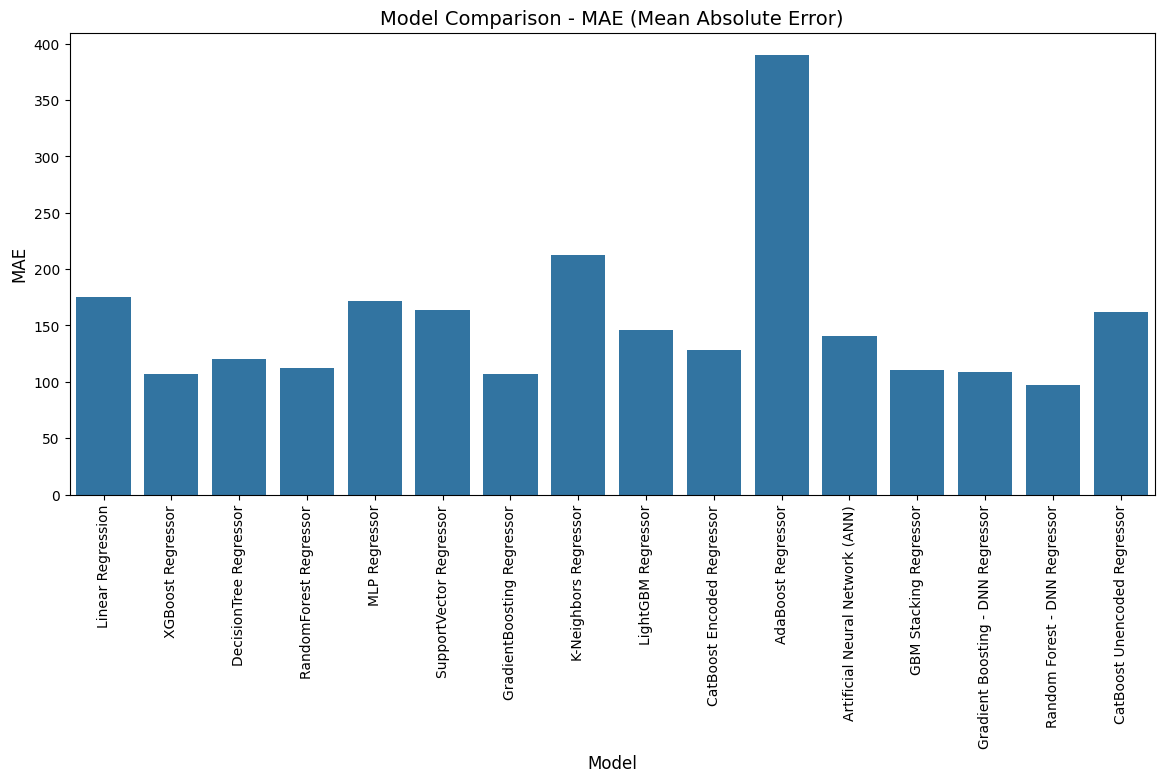

In [130]:
# Plot the MAE for each model

plt.figure(figsize=(14, 6))
sns.barplot(x="Model", y="MAE", data=results)

# Add title and labels
plt.title("Model Comparison - MAE (Mean Absolute Error)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.xticks(rotation=90)
plt.show()

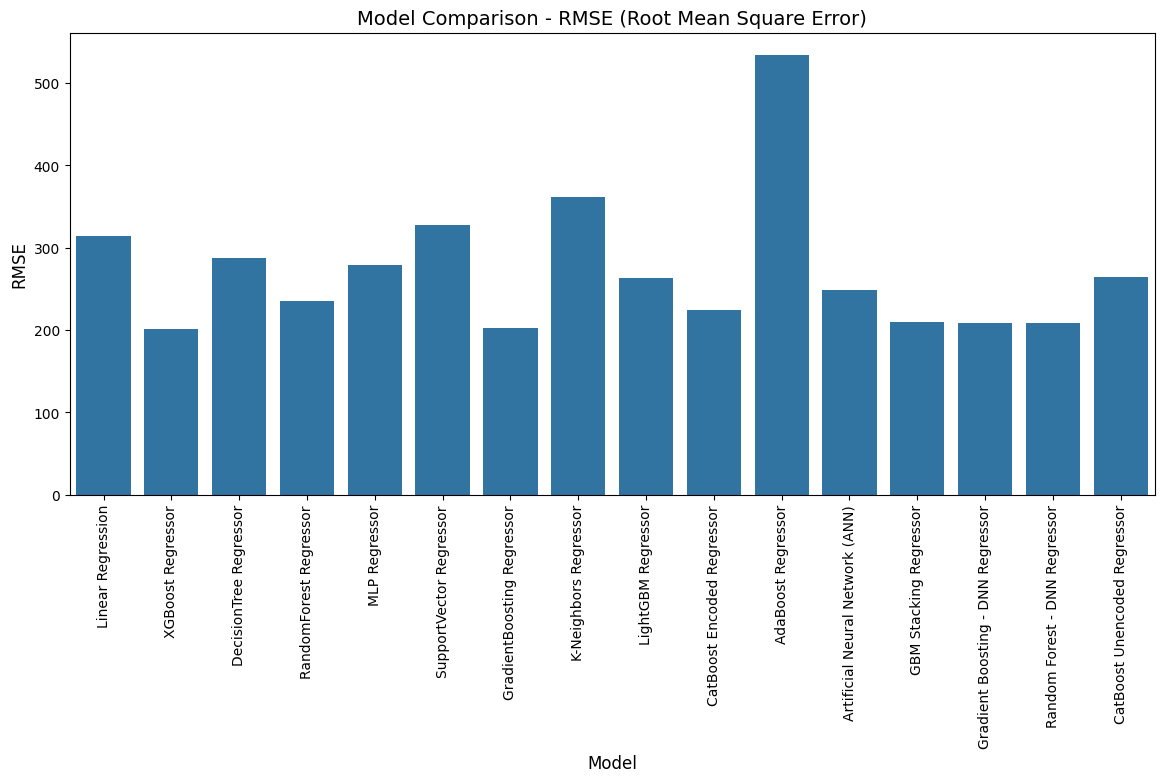

In [131]:
# Plot the RMSE for each model

plt.figure(figsize=(14, 6))
sns.barplot(x="Model", y="RMSE", data=results)

# Add title and labels
plt.title("Model Comparison - RMSE (Root Mean Square Error)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=90) 
plt.show()

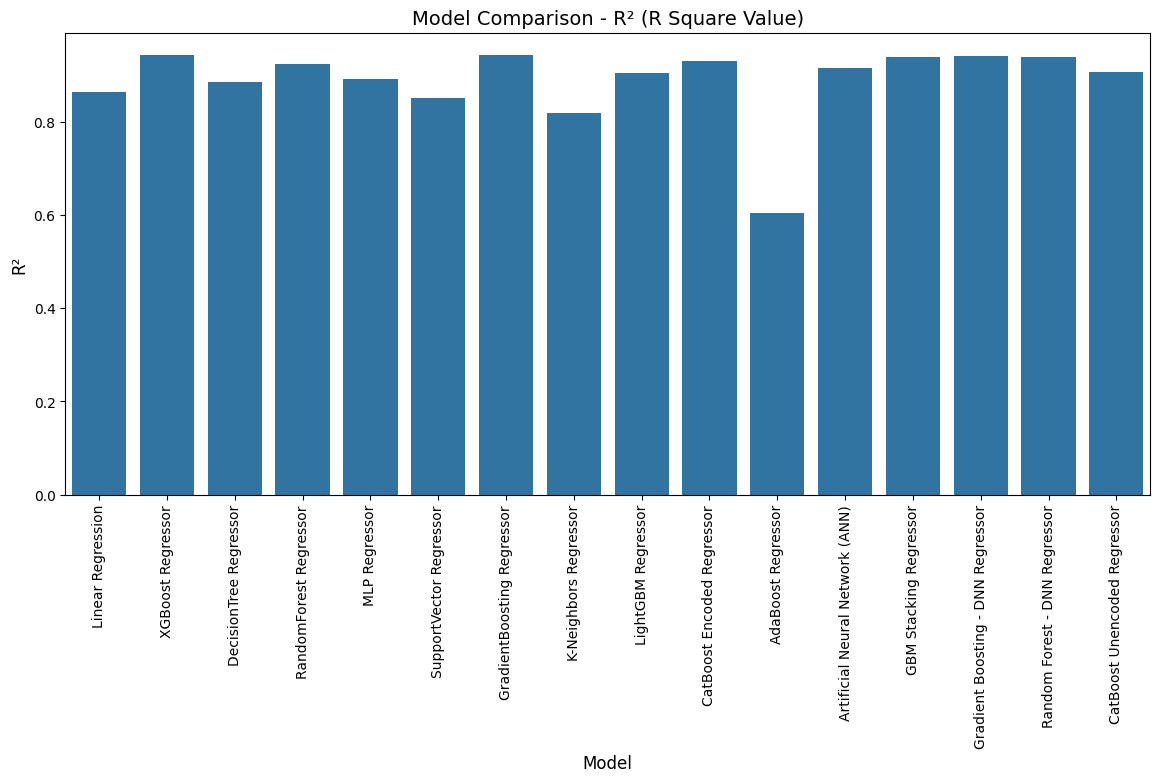

In [132]:
# Plot the R² for each model

plt.figure(figsize=(14, 6))
sns.barplot(x="Model", y="R²", data=results)

# Add title and labels
plt.title("Model Comparison - R² (R Square Value)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("R²", fontsize=12)
plt.xticks(rotation=90) 
plt.show()

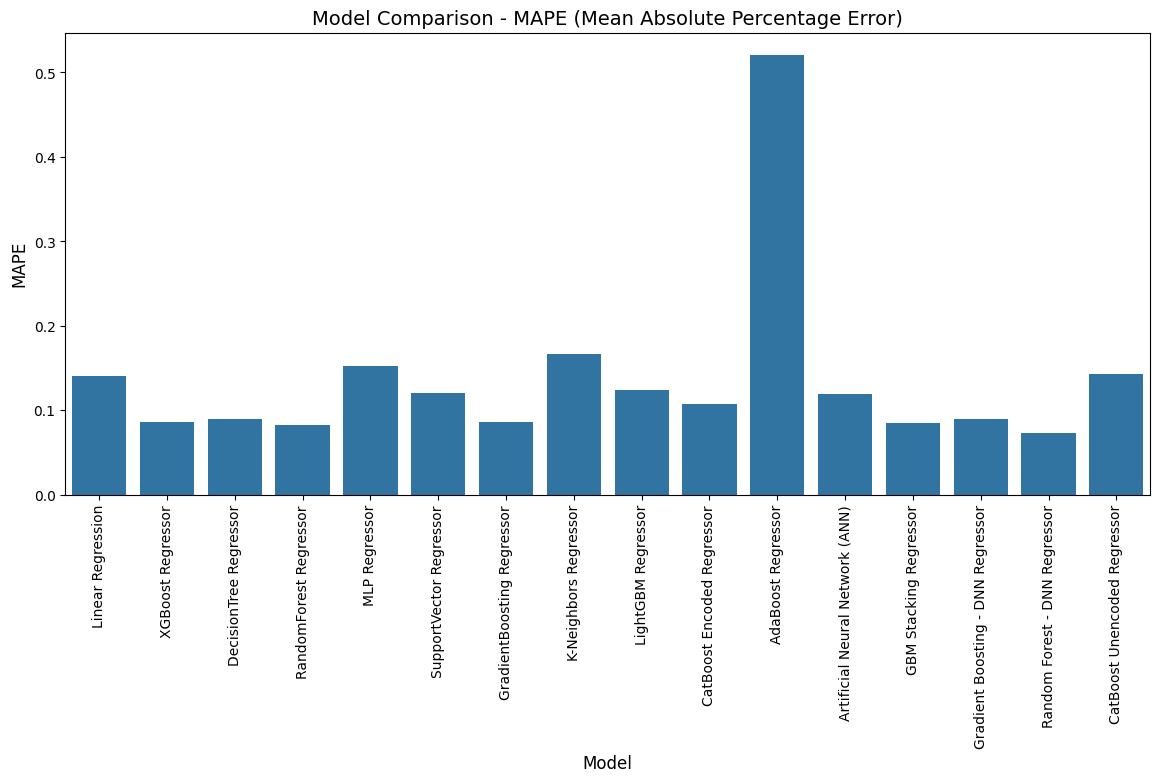

In [133]:
# Plot the R² for each model

plt.figure(figsize=(14, 6))
sns.barplot(x="Model", y="MAPE", data=results)

# Add title and labels
plt.title("Model Comparison - MAPE (Mean Absolute Percentage Error)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=90) 
plt.show()

In [134]:
# Among all the models, GradientBoosting Regressor has the highest performance, following with XGBoost Regressor and RandomForest Regressor. 
# These models have the highest R² value and lowest RMSE value.

#Sort the models by R² in descending order and select the top 3 models
top_3_models = results.sort_values(by='R²', ascending=False).head(5)

# Select only the relevant columns: Model name and the desired metrics
top_3_models_filtered = top_3_models[['Model', 'R²']]

# Print the result
print(top_3_models_filtered)

                                Model        R²
1                   XGBoost Regressor  0.943747
6          GradientBoosting Regressor  0.943434
13  Gradient Boosting - DNN Regressor  0.939933
14      Random Forest - DNN Regressor  0.939390
12             GBM Stacking Regressor  0.938829


In [135]:
# Among all the models, GradientBoosting Regressor has the highest performance, following with XGBoost Regressor and RandomForest Regressor. 
# These models have the highest R² value and lowest RMSE value.

#Sort the models by R² in descending order and select the top 3 models
top_3_models = results.sort_values(by='MAPE', ascending=True).head(5)

# Select only the relevant columns: Model name and the desired metrics
top_3_models_filtered = top_3_models[['Model', 'MAPE']]

# Print the result
print(top_3_models_filtered)

                            Model      MAPE
14  Random Forest - DNN Regressor  0.072546
3          RandomForest Regressor  0.081897
12         GBM Stacking Regressor  0.084259
6      GradientBoosting Regressor  0.086064
1               XGBoost Regressor  0.086348


In [136]:
# Among all the models, GradientBoosting Regressor has the highest performance, following with XGBoost Regressor and RandomForest Regressor. 
# These models have the highest R² value and lowest RMSE value.

#Sort the models by R² in descending order and select the top 3 models
top_3_models = results.sort_values(by='MAE', ascending=True).head(5)

# Select only the relevant columns: Model name and the desired metrics
top_3_models_filtered = top_3_models[['Model', 'MAE']]

# Print the result
print(top_3_models_filtered)

                                Model         MAE
14      Random Forest - DNN Regressor   97.092894
1                   XGBoost Regressor  107.018977
6          GradientBoosting Regressor  107.036196
13  Gradient Boosting - DNN Regressor  108.481521
12             GBM Stacking Regressor  110.438112


In [137]:
# Among all the models, GradientBoosting Regressor has the highest performance, following with XGBoost Regressor and RandomForest Regressor. 
# These models have the highest R² value and lowest RMSE value.

#Sort the models by R² in descending order and select the top 3 models
top_3_models = results.sort_values(by='RMSE', ascending=True).head(5)

# Select only the relevant columns: Model name and the desired metrics
top_3_models_filtered = top_3_models[['Model', 'RMSE']]

# Print the result
print(top_3_models_filtered)

                                Model        RMSE
1                   XGBoost Regressor  201.365753
6          GradientBoosting Regressor  201.926662
13  Gradient Boosting - DNN Regressor  208.081246
14      Random Forest - DNN Regressor  209.018782
12             GBM Stacking Regressor  209.984820


# *

In [138]:
pd.set_option('display.max_rows', None)

In [139]:
pd.set_option('display.max_columns', None)

In [140]:
pd.reset_option('display.max_rows')

In [141]:
pd.reset_option('display.max_columns')

# Appendix

In [142]:
"""
Linear Regression (Baseline)
Decision Tree Regressor
Random Forest Regressor
Gradient Boosting Regressor (GBR)
XGBoost Regressor
LightGBM Regressor
CatBoost Regressor
Support Vector Regressor (SVR)
Neural Networks (MLP Regressor - optional)

"""

'\nLinear Regression (Baseline)\nDecision Tree Regressor\nRandom Forest Regressor\nGradient Boosting Regressor (GBR)\nXGBoost Regressor\nLightGBM Regressor\nCatBoost Regressor\nSupport Vector Regressor (SVR)\nNeural Networks (MLP Regressor - optional)\n\n'

In [143]:
"""
### All Model Training
# Define models and hyperparameters
models = {
    "LinearRegression": (LinearRegression(), {}),
    "DecisionTree": (DecisionTreeRegressor(), {
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10]
    }),
    "RandomForest": (RandomForestRegressor(), {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5, 10]
    }),
    "GradientBoosting": (GradientBoostingRegressor(), {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 10]
    }),
    "XGBoost": (XGBRegressor(), {
        "n_estimators": [100, 200, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7]
    }),
    "SVR": (SVR(), {
        "C": [0.1, 1, 10],
        "epsilon": [0.01, 0.1, 0.2],
        "kernel": ["linear", "rbf"]
    }),
    "MLP": (MLPRegressor(max_iter=500), {
        "hidden_layer_sizes": [(50,), (100,), (50,50), (100,50)],
        "activation": ["relu", "tanh"],
        "alpha": [0.0001, 0.001, 0.01]
    })
}
"""
"""
    "LightGBM": (LGBMRegressor(), {
        "n_estimators": [100, 200, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "num_leaves": [31, 50, 100]
    }),
    "CatBoost": (CatBoostRegressor(verbose=0), {
        "iterations": [100, 500, 1000],
        "learning_rate": [0.01, 0.05, 0.1],
        "depth": [3, 6, 10]
    }),
"""
"""# Train and evaluate models
best_model = None
best_score = float("inf")

for name, (model, params) in models.items():
    print(f"Training {name}...")
    #pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    
    if params:
        search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
        search.fit(X_train, y_train)
        best_model_instance = search.best_estimator_
    else:
        best_model_instance = model.fit(X_train, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(best_model_instance, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    print(f"{name} - Cross-validation MAE: {-cv_scores.mean()} ± {cv_scores.std()}")
    
    # Model evaluation
    y_pred = best_model_instance.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R² Score: {r2}\n")
    
    if mae < best_score:
        best_score = mae
        best_model = best_model_instance

print(f"Best model: {best_model}")"""


'# Train and evaluate models\nbest_model = None\nbest_score = float("inf")\n\nfor name, (model, params) in models.items():\n    print(f"Training {name}...")\n    #pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])\n\n    if params:\n        search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)\n        search.fit(X_train, y_train)\n        best_model_instance = search.best_estimator_\n    else:\n        best_model_instance = model.fit(X_train, y_train)\n\n    # Cross-validation\n    cv_scores = cross_val_score(best_model_instance, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")\n    print(f"{name} - Cross-validation MAE: {-cv_scores.mean()} ± {cv_scores.std()}")\n\n    # Model evaluation\n    y_pred = best_model_instance.predict(X_test)\n    mae = mean_absolute_error(y_test, y_pred)\n    mse = mean_squared_error(y_test, y_pred)\n    rmse = np.sqrt(mse)\n    r2 = r2_score(y_test

In [144]:
"""
# Initialize the MLP Regressor
mlp_model = MLPRegressor()

# Define the hyperparameter grid for tuning
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (100, 100, 50)],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [200, 500, 1000],
    'early_stopping': [True, False]
}

# Initialize Grid Search
mlp_grid_search = GridSearchCV(
    estimator=mlp_model,  # Base model
    param_grid=mlp_param_grid,  # Hyperparameter grid
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Print progress
)

# Train the model with Grid Search
mlp_grid_search.fit(X_train, y_train)

# Get the best model
tuned_mlp_model = mlp_grid_search.best_estimator_

# Get the best hyperparameters
mlp_best_params = mlp_grid_search.best_params_
print("Best Hyperparameters:", mlp_best_params)

"""

'\n# Initialize the MLP Regressor\nmlp_model = MLPRegressor()\n\n# Define the hyperparameter grid for tuning\nmlp_param_grid = {\n    \'hidden_layer_sizes\': [(50,), (100,), (50, 50), (100, 100), (100, 100, 50)],\n    \'solver\': [\'adam\', \'sgd\', \'lbfgs\'],\n    \'learning_rate\': [\'constant\', \'adaptive\'],\n    \'learning_rate_init\': [0.0001, 0.001, 0.01],\n    \'alpha\': [0.0001, 0.001, 0.01, 0.1],\n    \'max_iter\': [200, 500, 1000],\n    \'early_stopping\': [True, False]\n}\n\n# Initialize Grid Search\nmlp_grid_search = GridSearchCV(\n    estimator=mlp_model,  # Base model\n    param_grid=mlp_param_grid,  # Hyperparameter grid\n    scoring=\'neg_mean_squared_error\',  # Evaluation metric\n    cv=5,  # Number of cross-validation folds\n    n_jobs=-1,  # Use all available CPU cores\n    verbose=2  # Print progress\n)\n\n# Train the model with Grid Search\nmlp_grid_search.fit(X_train, y_train)\n\n# Get the best model\ntuned_mlp_model = mlp_grid_search.best_estimator_\n\n# Get 